# 3 Dimensional Tracer Inversion

The real ocean has been observed to be rich in variability at large range of length and time scales. Models of the ocean are limited by resolution, and can not simulate all the true variability. However, it is a well known fact that the variability at small scales is capable of signficantly influencing the mean (large-scale) variables, eg eddies spread tracer around more than simply advection by the mean. A large body of literature has been written in trying to address the best and dynamically correct practices for **parameterizing** the unresolved motions, and our current coarse resolution ocean circulation models rely on these parameterizations. The 2 regularly employed parameterizations are the Gent and McWilliams parameterization for "diffusing" buoyancy or thickness in accordance with baroclinic instability, and the Redi parameterization for diffusing tracers primarily along isopycnal surfaces with a controlled diabatic diffusion rate. 

The eddy diffusivity tensor ($\mathbf{K}$) is the parameter that is used as input in these parameterizations. While a lot of previous attempts have been made previously to estimate these parameters based on simplistic mixing length arguments, no winning strategy has emerged. This is in part due to the lack of observations of the true/best eddy diffusivity that corresponds to a flow field (some observations have been made, but not seemingly enough to test if the relationships of the diffusivity to the large scale variables are correct). An alternate route is to estimate the eddy diffusivities in a high resolution simulation, and use this as a test bed. Bachman and Fox-Kemper 2013 and Abernathey et al 2013 are two studies that calculated the entire diffusivity tensor (2X2 matrix) from a 2D (3D but zonally symmetric) eddy resolving simulation. We would like to note that numerous investigators have estimated eddy diffusivities in model simulations, but most of them have focussed on estimating some part of the full tensor - eg. Colas et al 2013 calculated the antisymmetric component, while studies using tracers or particles have recovered the terms of the symmetric part, similarly observations have been focussed mostly on estimating the across-mean flow components of the eddy diffusivity. 

*Even though these eddy tensor estimation techniques have been around for 3 decades, we have not been able to find any studies trying to estimate these parameters in a complex domain, or testing the skill of these techniques.* 

Here is what we suggest doing. We take a channel simulation, which has previously been the test bed for the zonally symmetric parameter estimation problems, and add the complexity of a meridional ridge to break the symmetry. This creates a flow that is complex enough, and we test if we can use the multi-tracer inversion method to estimate the true eddy parameters. The two main elements of complexity are: a) there are regions with high and low EKE, which are usually thought to be order one factors in controlling the eddy parameters, b) there are complex mean flows, example meanders etc. 


## Model Setup 

The zonal channel model is forced using winds (sinusoidal wind ; *not sin^2 like the other paper*) and linear buoyancy restoration at the surface. The north, south and bottom boundaries are insulating and stress free. The physical model is run to equilibrium (101 years), before introducing tracers into the domain. 

In [2]:
# load modules 

import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
import os 
from xgcm import Grid
from xarrayutils import aggregate
import copy
# Pseudo Inversion 
from scipy.linalg import pinv, eig

In [ ]:
# Aux functions (can put into python script)

# Function to calculate the gradients
def tracer_grads(ds, ds_full):
    
    grid = Grid(ds_full, periodic='X')
    
    dx = ds_full.dxC.mean('YC')
    dy = ds_full.dyC.mean('XC')
    dz = ds_full.drF
    
    trac_dx = grid.interp(grid.diff(ds,'X')/dx, 'X')
    
    trac_dy = grid.interp(grid.diff(ds,'Y', boundary = 'extend')/dy, 'Y',boundary='extend')
    
    trac_dz = - grid.interp(grid.diff(ds,'Z', boundary = 'extend'), 'Z',boundary='extend')/dz

    trac_dx= trac_dx.rename('dcdx')
    trac_dy= trac_dy.rename('dcdy')
    trac_dz= trac_dz.rename('dcdz')
    
    grads = xr.merge([trac_dx, trac_dy, trac_dz])
    return grads

In [6]:
data_dir = '/swot/SUM05/dbalwada/channel_model_output/varying_res/05km/multi_tracer_montly_restored/multi_tracer/'

# brief comment on how often was the model data saved 
# the mode outputs fields every 5 days, averages are also
# calculated over 5 days (*this creates stupid amounts of 
# unnecessary data, and was definitely a terrible idea in hidsight).
# 

iters = range(10473120, 10473120+518400*4, 1440)
model_vars = ['uVeltave','vVeltave','wVeltave', 'Ttave', 'ETAtave']
ds_model = open_mdsdataset(data_dir , delta_t=300, iters=iters, 
                          prefix=model_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [1165]:
# Velocity and temperature time mean
Model_tav = ds_model.mean('time')
Model_tav.load()

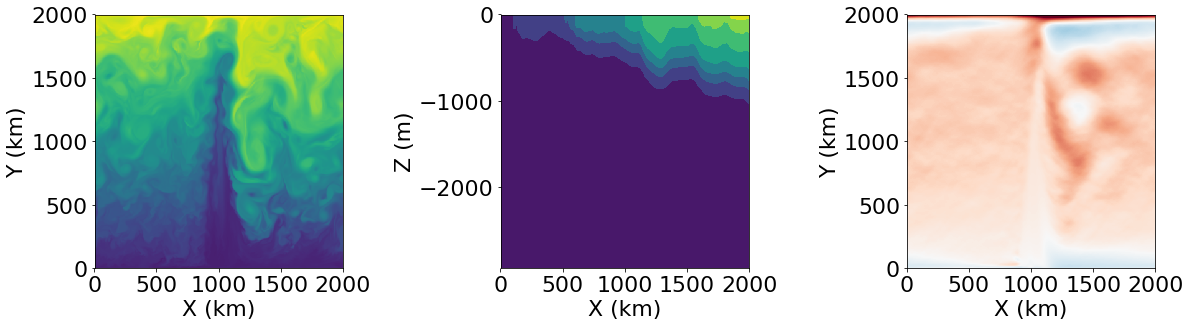

In [30]:
# have a few plots (multipanel?) to show what the model looks like. 

plt.figure(figsize=(17,5))
plt.rcParams.update({'font.size': 22})

X = ds_model.XC 
Y = ds_model.YC 
Z = ds_model.Z 

plt.subplot(131)
plt.pcolormesh(X/1e3, Y/1e3, ds_model.Ttave.isel(time=-1, Z=0))
plt.xlabel('X (km)')
plt.ylabel('Y (km)')

plt.subplot(132)
plt.contourf(X/1e3, Z, ds_model.Ttave.isel(time=-1, XC=0))
plt.xlabel('X (km)')
plt.ylabel('Z (m)')

plt.subplot(133)
plt.pcolormesh(X/1e3, Y/1e3, Model_tav.uVeltave.isel(Z=0), vmin=-0.4, vmax=0.4, cmap='RdBu_r')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')


plt.tight_layout()

### Tracer initializations and runs

We would like the model to solve the tracer advection-diffusion equation,
\begin{equation}
\frac{\partial c}{\partial t} + \mathbf{u}.\nabla c = 0,
\end{equation}
using the model generated velocity fields. The important thing to note is that there are no source of sinks of tracers on the RHS. 

If we split the variables into the mean and the eddy terms, $c = C + c'$ , then we get an equation for the mean tracer, 
\begin{equation}
\frac{\partial C}{\partial t} + \mathbf{U}. \nabla C = -\nabla.(\overline{\mathbf{u'}c'}).
\end{equation}
The goal of a tracer eddy parameterization scheme is to represent the eddy flux on the RHS. 

The eddy diffusivity tensor is used to parameterize the eddy flux as,
\begin{equation}
\overline{\mathbf{u'}c'} = - \mathbf{K} \nabla C.
\end{equation}
It is assumed that the same $\mathbf{K}$ applies to all the tracers. This might not be true if different tracers have different source functions. This expression is a 3 equation set, so if we had 3 different different (orthogonal) tracer gradients then we can invert this equation for the $\mathbf{K}$. Here we over fit the problem by using 10 different tracers. (** add some plots for different tracer orientations**)

As we are not using any forcing function to maintain the tracer gradeints, the flow field will mix away all the gradients as time progresses. So, instead of waiting for a long time we carry out an ensemble of simulations, where each tracer field is restarted every month (30 days). We carry out these monthly re-release experiments for 20 years, implying 240 tracer release experiments (** probably some sort of convergence test can be done for the statistics of the fluxes.**). 

In [4]:
# There are 10 tracer fields, for which C, UT, VT, WT averaged over 5 days
# are saved.
data_dir = '/swot/SUM05/dbalwada/channel_model_output/varying_res/05km/multi_tracer_montly_restored/multi_tracer/'

iters = range(10473120, 10473120+518400*4, 1440)
tracer_vars = ['tracer1_diag', 'tracer2_diag', 'tracer3_diag', 
               'tracer4_diag', 'tracer5_diag', 'tracer6_diag',
               'tracer7_diag', 'tracer8_diag', 'tracer9_diag',
               'tracer10_diag']

ds_tracer = open_mdsdataset(data_dir , iters= iters, delta_t=300,
                          prefix=tracer_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [ ]:
# time averge the tracer fields
tav_trac = ds_tracer.mean('time')
tav_trac.load()
tav_trac.to_netcdf('tav_trac.nc')

#### We need to check at what stage do the statistics converge? 
Is temporal averaging sufficient for the statistics (values of flux) to have converged? Or do we need to do spatial averaging as well? 

One way to check this by checking how signficantly the tracer fluxes change by adding more data. 
First we estimate
\begin{equation}
VC (T) = \frac{\sum_1^T VC}{T}
\end{equation}

as T goes to $\infty$, we would expect $VC(\infty)$ to converge. 

To check for convergence we estimate the relative change : 
\begin{equation}
\delta VC(T) = \frac{VC(T+1) - VC(T)}{VC(T_{max})}
\end{equation}

As can be seen in the figures below the relative change is generally less than 1% for the horizontal fluxes, and less than 10% for the vertical fluxes. 


In [255]:
%%time
# how long does it take for w'c' to converge (without any spatial averaging )
n=1439
time_ax = ds_tracer.time.isel(time=slice(-n,-1))  - ds_tracer.time.isel(time=-n)
flux = ds_tracer.VTRAC01.sel(XC=0, YG=1000e3, Z=0, method='nearest').isel(time=slice(-n,-1)).cumsum()/time_ax

CPU times: user 5.32 s, sys: 504 ms, total: 5.82 s
Wall time: 5.31 s


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


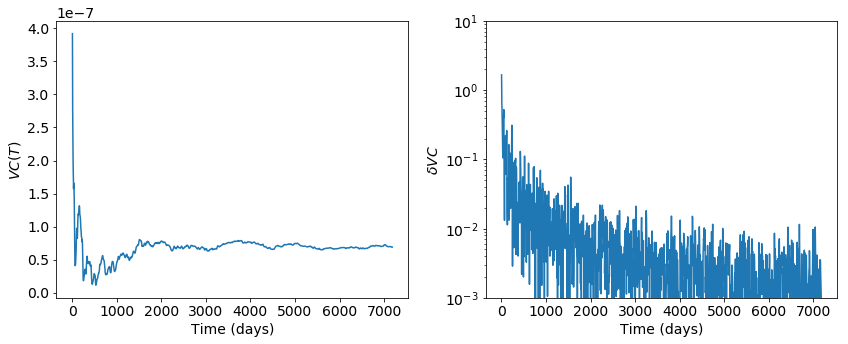

In [256]:
plt.figure(figsize=(12,5)) 

plt.subplot(121)
plt.plot(time_ax/24/3600, flux)
plt.xlabel('Time (days)')
plt.ylabel('$ VC (T)$ ')
plt.title('')

plt.subplot(122)
plt.plot(time_ax[0:-1]/24/3600, np.abs((flux.diff('time')/flux[-1])))
plt.yscale('log')
plt.xlabel('Time (days)')
plt.ylabel('$\delta VC$')
plt.ylim([0.001, 10])

plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


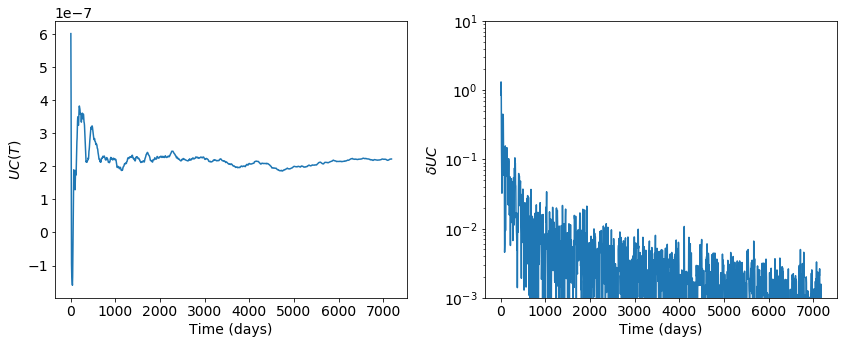

In [180]:
n=1439
time_ax = ds_tracer.time.isel(time=slice(-n,-1))  - ds_tracer.time.isel(time=-n)
flux = ds_tracer.UTRAC03.sel(XG=1200e3, YC=1000e3, Z=0, method='nearest').isel(time=slice(-n,-1)).cumsum()/time_ax
plt.figure(figsize=(12,5)) 

plt.subplot(121)
plt.plot(time_ax/24/3600, flux)
plt.xlabel('Time (days)')
plt.ylabel('$ UC (T)$')
plt.title('')

plt.subplot(122)
plt.plot(time_ax[0:-1]/24/3600, np.abs((flux.diff('time')/flux[-1])))
plt.yscale('log')
plt.xlabel('Time (days)')
plt.ylabel('$\delta UC$')
plt.ylim([0.001, 10])

plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


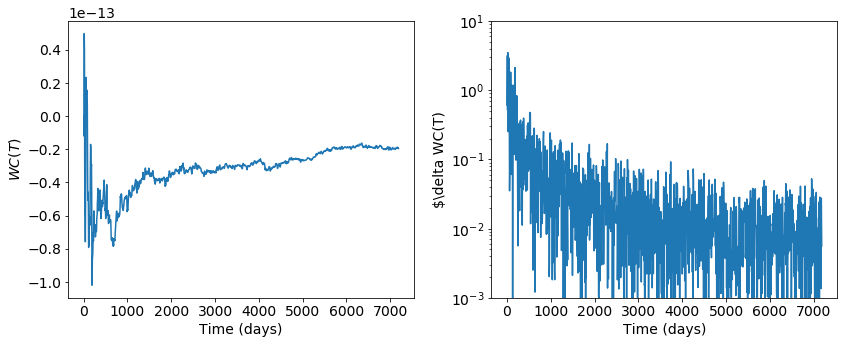

In [181]:
n=1439
time_ax = ds_tracer.time.isel(time=slice(-n,-1))  - ds_tracer.time.isel(time=-n)
flux = ds_tracer.WTRAC07.sel(XC=0, YC=1000e3, Z=0, method='nearest').isel(time=slice(-n,-1)).cumsum()/time_ax
plt.figure(figsize=(12,5)) 

plt.subplot(121)
plt.plot(time_ax/24/3600, flux)
plt.xlabel('Time (days)')
plt.ylabel('$ WC (T)$')
plt.title('')

plt.subplot(122)
plt.plot(time_ax[0:-1]/24/3600, np.abs((flux.diff('time')/flux[-1])))
plt.yscale('log')
plt.xlabel('Time (days)')
plt.ylabel('$\delta WC(T)')         
plt.ylim([0.001, 10])

plt.tight_layout()

## How well are the results converged??

In [1474]:
uc = ds_tracer.UTRAC01 - grid.interp(UtavCtav['TRAC01']['uVeltave'], 'X')
vc = ds_tracer.VTRAC01 - grid.interp(UtavCtav['TRAC01']['vVeltave'], 'Y', boundary='extend')
wc = ds_tracer.WTRAC01 - UtavCtav['TRAC01']['wVeltave']

In [1557]:
with ProgressBar():
    trac_clim = trac.groupby('weeks').mean('time').compute()

[########################################] | 100% Completed |  1min 26.0s


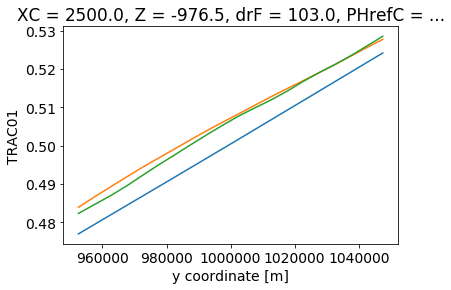

In [1569]:
trac_clim.sel(Z=-1000, method='nearest', XC=0).isel(weeks=0).sel(YC=slice(950e3,1050e3)).plot()
trac_clim.sel(Z=-1000, method='nearest', XC=0).isel(weeks=2).sel(YC=slice(950e3,1050e3)).plot()
trac_clim.sel(Z=-1000, method='nearest', XC=0).isel(weeks=4).sel(YC=slice(950e3,1050e3)).plot()

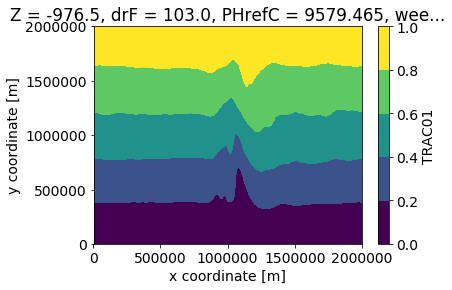

In [1565]:
trac_clim.sel(Z=-1000, method='nearest').isel(weeks=5).plot.contourf()

In [1476]:
trac_clim

In [1496]:
trac.coords['weeks'] = ('time', np.tile(range(0,6),240))

In [1424]:
from dask.diagnostics import ProgressBar

In [1441]:
with ProgressBar():
    uc_up = uc.sel(YC=slice(950e3, 1050e3), XG=slice(50e3,150e3)).sel(Z=-1000, method='nearest').groupby('weeks').mean('time').compute()
    vc_up = vc.sel(YG=slice(950e3, 1050e3), XC=slice(50e3,150e3)).sel(Z=-1000, method='nearest').groupby('weeks').mean('time').compute()

[########################################] | 100% Completed |  9.8s
[########################################] | 100% Completed | 10min 20.6s


ValueError: dimensions or multi-index levels ['XC'] do not exist

In [1478]:
with ProgressBar():
    wc_up = wc.sel(YC=slice(950e3, 1050e3), XC=slice(50e3,150e3)).sel(Z=-1000, method='nearest').groupby('weeks').mean('time').compute()

[########################################] | 100% Completed | 11.7s


In [1497]:
with ProgressBar(): 
    trac_up = trac.sel(YC=slice(950e3, 1050e3), XC=slice(50e3,150e3)).sel(Z=-1000, method='nearest').groupby('weeks').mean('time').compute()

[########################################] | 100% Completed |  9.1s


In [1500]:
grid_small = Grid(Model_tav.sel(YC=slice(950e3, 1050e3), XC=slice(50e3,150e3), YG=slice(950e3, 1050e3), XG=slice(50e3,150e3))
                 , periodic='none')

In [1503]:
trac

<xgcm.Grid>
Z Axis (not periodic):
  * center   Z (40) --> left
  * left     Zl (40) --> center
  * outer    Zp1 (41) --> center
  * right    Zu (40) --> center
X Axis (not periodic):
  * center   XC (20) --> outer
  * outer    XG (21) --> center
Y Axis (not periodic):
  * center   YC (20) --> outer
  * outer    YG (21) --> center

In [1519]:
Cx_up = grid_small.diff(trac_up, 'X', boundary='extend')/5e3
Cy_up = grid_small.diff(trac_up, 'Y', boundary='extend')/5e3

In [1530]:
Cy_xmean = grid_small.diff(trac_up.mean('XC'), 'Y', boundary='extend')/5e3

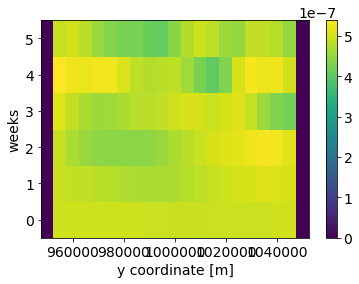

In [1531]:
Cy_xmean.plot()

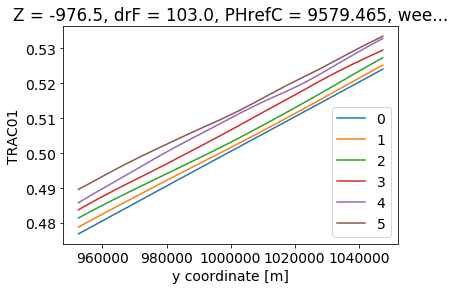

In [1532]:
for i in range(6):
    trac_up.isel(weeks=i).mean('XC').plot()
plt.legend(range(6))

In [1551]:
cy_coarse = -( trac_up.mean('XC').sel(YC=slice(950e3, 1000e3)).mean('YC') - trac_up.mean('XC').sel(YC=slice(1000e3, 1050e3)).mean('YC'))/50e3
cx_coarse = -(trac_up.mean('YC').sel(XC=slice(50e3,100e3)).mean('XC') - trac_up.mean('YC').sel(XC=slice(100e3,150e3)).mean('XC'))/50e3

In [1549]:
vc_coarse = vc_up.mean('XC').sel(YG=slice(975e3,1025e3)).mean('YG')
uc_coarse = uc_up.mean('XG').sel(YC=slice(975e3,1025e3)).mean('YC')

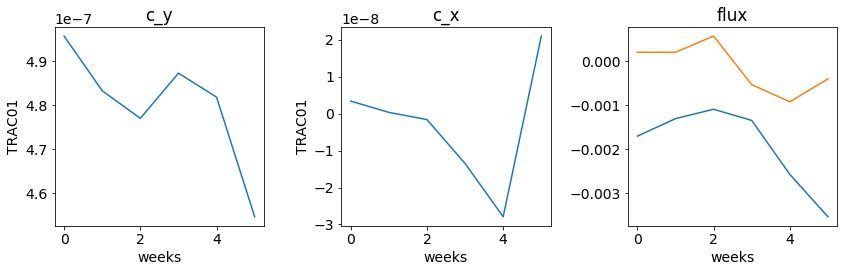

In [1554]:
plt.figure(figsize=(12,4))
plt.subplot(131)
cy_coarse.plot()
plt.title('c_y')

plt.subplot(132)
cx_coarse.plot()
plt.title('c_x')

plt.subplot(133)
vc_coarse.plot()
uc_coarse.plot()
plt.title('flux')

plt.tight_layout()

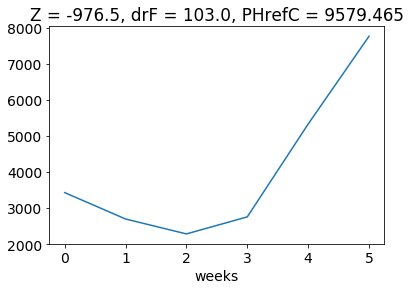

In [1548]:
(-vc_coarse/cy_coarse).plot()

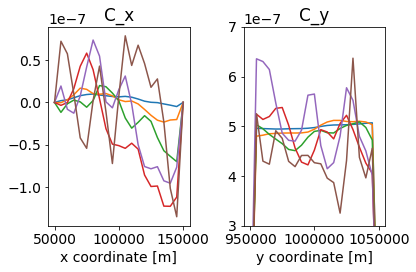

In [1522]:
plt.subplot(121)
for i in range(6):
    Cx_up.isel(weeks=i, YC=0).plot()
plt.title('C_x')
    
plt.subplot(122)
for i in range(6):
    Cy_up.isel(weeks=i, XC=0).plot()    
plt.ylim([3e-7, 7e-7])    
plt.title('C_y')

plt.tight_layout()

(4e-07, 6e-07)

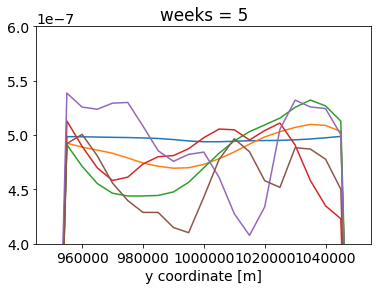

In [1524]:
for i in range(6):
    Cy_up.isel(weeks=i).mean('XC').plot()    
plt.ylim([4e-7, 6e-7])    

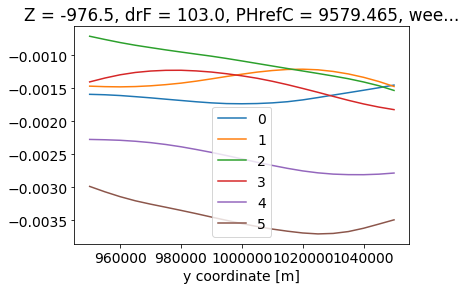

In [1528]:
for i in range(6):
    vc_up.isel(weeks=i).mean('XC').plot()   
plt.legend(range(6))    

Text(0.5,1,"u'c' convergence")

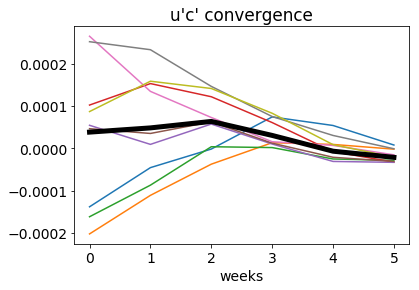

In [1465]:
(uc_up.isel(XG=0,YC=0).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=10,YC=0).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=19,YC=0).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=0,YC=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=10,YC=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=19,YC=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=0,YC=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=10,YC=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=19,YC=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()

(uc_up.mean(['XG','YC']).cumsum('weeks')/(uc_up.weeks+1)/5).plot(color='k',linewidth=5)

plt.title('u\'c\' convergence')

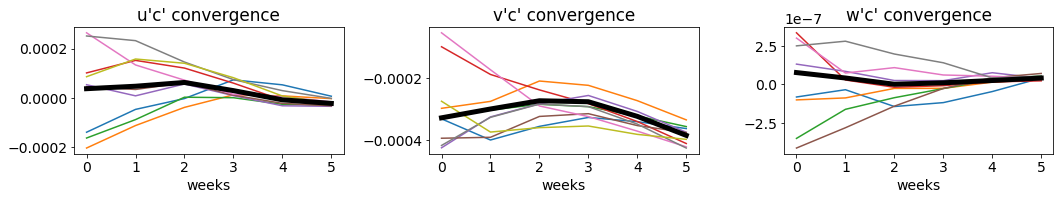

In [1482]:
plt.figure(figsize=(15,3))
plt.subplot(131)
(uc_up.isel(XG=0,YC=0).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=10,YC=0).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=19,YC=0).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=0,YC=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=10,YC=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=19,YC=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=0,YC=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=10,YC=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.isel(XG=19,YC=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(uc_up.mean(['XG','YC']).cumsum('weeks')/(uc_up.weeks+1)/5).plot(color='k',linewidth=5)
plt.title('u\'c\' convergence')

plt.subplot(132)
(vc_up.isel(XC=0,YG=0).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(vc_up.isel(XC=10,YG=0).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(vc_up.isel(XC=19,YG=0).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(vc_up.isel(XC=0,YG=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(vc_up.isel(XC=10,YG=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(vc_up.isel(XC=19,YG=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(vc_up.isel(XC=0,YG=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(vc_up.isel(XC=10,YG=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(vc_up.isel(XC=19,YG=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(vc_up.mean(['XC','YG']).cumsum('weeks')/(uc_up.weeks+1)/5).plot(color='k',linewidth=5)
plt.title('v\'c\' convergence')

plt.subplot(133)
(wc_up.isel(XC=10,YC=0).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(wc_up.isel(XC=19,YC=0).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(wc_up.isel(XC=0,YC=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(wc_up.isel(XC=10,YC=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(wc_up.isel(XC=19,YC=10).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(wc_up.isel(XC=0,YC=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(wc_up.isel(XC=10,YC=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(wc_up.isel(XC=19,YC=19).cumsum('weeks')/(uc_up.weeks+1)/5).plot()
(wc_up.mean(['XC','YC']).cumsum('weeks')/(uc_up.weeks+1)/5).plot(color='k',linewidth=5)
plt.title('w\'c\' convergence')

plt.tight_layout()

In [1491]:
((vc_up.mean(['XC','YG']).cumsum('weeks')/(uc_up.weeks+1)/5).max() 
 - (vc_up.mean(['XC','YG']).cumsum('weeks')/(uc_up.weeks+1)/5).min()
)/(vc_up.mean(['XC','YG']).cumsum('weeks')/(uc_up.weeks+1)/5).mean()



<xarray.DataArray ()>
array(-0.355929)
Coordinates:
    Z        >f4 -976.5
    drF      float32 103.0
    PHrefC   float32 9579.465

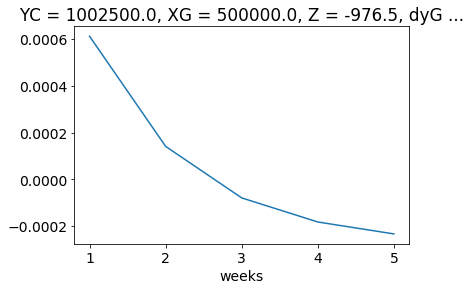

In [1437]:
(uc.cumsum('weeks')/uc.weeks).plot()

In [ ]:
# Calculate Ubar Cbar
# will be used to estimate the u'c' = (uc - UbarCbar)

#UtavCtav = {}

#for k in list_tracers:
#    print(k)
#    temp = {}
#    for j in list_vels:
#        
 #       if j == 'uVeltave':
 #           temp[j] = grid.interp(Model_tav[j],'X')*tav_trac[k]
        
 #       elif j == 'vVeltave':
 #           temp[j] = grid.interp(Model_tav[j],'Y', boundary='extend')*tav_trac[k]
        
 #       elif j == 'wVeltave':
 #           temp[j] = grid.interp(Model_tav[j], 'Z', boundary='extend')*tav_trac[k]
            
 #   UtavCtav[k] = copy.deepcopy(temp)

In [1575]:
cp = trac.groupby('weeks') - trac_clim

In [1576]:
cp

<xarray.DataArray 'TRAC01' (time: 1440, Z: 40, YC: 400, XC: 400)>
dask.array<shape=(1440, 40, 400, 400), dtype=float32, chunksize=(1440, 40, 400, 400)>
Coordinates:
  * YC       (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XC       (XC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
    rA       (YC, XC) >f4 25000000.0 25000000.0 ... 25000000.0 25000000.0
    Depth    (YC, XC) >f4 0.0 0.0 0.0 0.0 0.0 ... 2985.0 2985.0 2985.0 2985.0
    drF      (Z) >f4 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0 103.0
    PHrefC   (Z) >f4 49.05 147.15 245.25 ... 26756.775 27767.205 28777.635
    hFacC    (Z, YC, XC) >f4 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    iter     (time) int64 dask.array<shape=(1440,), chunksize=(1,)>
  * time     (time) int64 3141936000 3142368000 ... 3763152000 3763584000
    weeks    (time) int64 0 1 2 3 4 5 0 1 2 3 4 5 0 ... 0 1 2 3 4 5 0

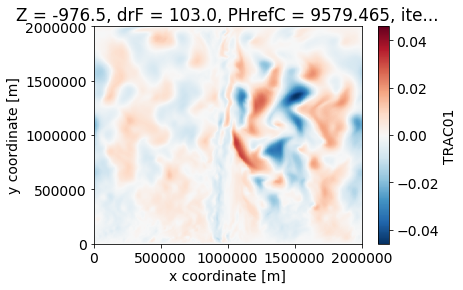

In [1621]:
cp.sel(Z=-1000, method='nearest').isel(time=0).plot()

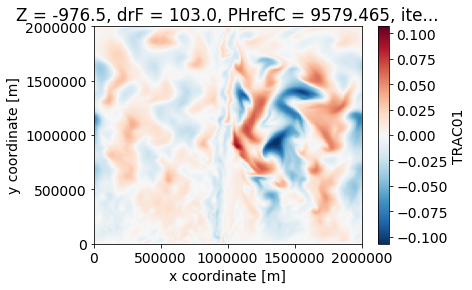

In [1578]:
cp.sel(Z=-1000, method='nearest').isel(time=1).plot()

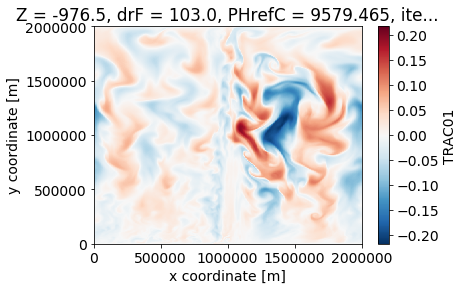

In [1579]:
cp.sel(Z=-1000, method='nearest').isel(time=3).plot()

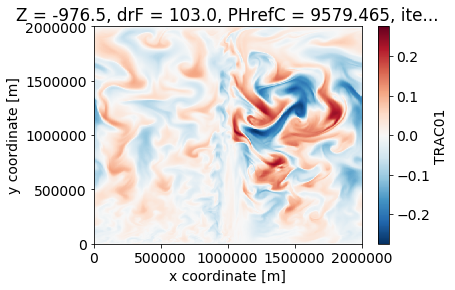

In [1580]:
cp.sel(Z=-1000, method='nearest').isel(time=5).plot()

In [ ]:
trac.coords['weeks'] = ('time', np.tile(range(0,6),240))

In [1581]:
vctot = ds_tracer.VTRAC01 

In [1582]:
vctot.coords['weeks'] = ('time', np.tile(range(0,6),240))

In [1584]:
vctot

<xarray.DataArray 'VTRAC01' (time: 1440, Z: 40, YG: 400, XC: 400)>
dask.array<shape=(1440, 40, 400, 400), dtype=float32, chunksize=(1, 40, 400, 400)>
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * YG       (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
    dxG      (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    dyC      (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    rAs      (YG, XC) >f4 25000000.0 25000000.0 ... 25000000.0 25000000.0
    drF      (Z) >f4 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0 103.0
    PHrefC   (Z) >f4 49.05 147.15 245.25 ... 26756.775 27767.205 28777.635
    hFacS    (Z, YG, XC) >f4 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    iter     (time) int64 dask.array<shape=(1440,), chunksize=(1,)>
  * time     (time) int64 3141936000 3142368000 ... 3763152000 37635

In [1585]:
vpcp = vctot.groupby('weeks') - Model_tav.vVeltave*grid.interp(trac_clim,'Y', boundary='extend')

In [1590]:
with ProgressBar():
    vpcp_bar = vpcp.groupby('weeks').mean('time').compute()

[########################################] | 100% Completed |  2min 38.3s


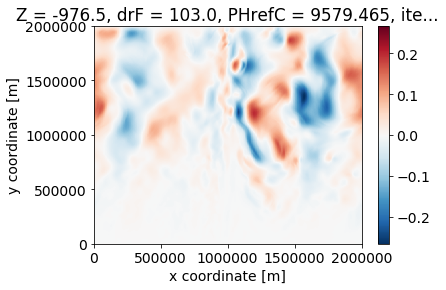

In [1589]:
vpcp.sel(Z=-1000, method='nearest').isel(time=-1).plot()

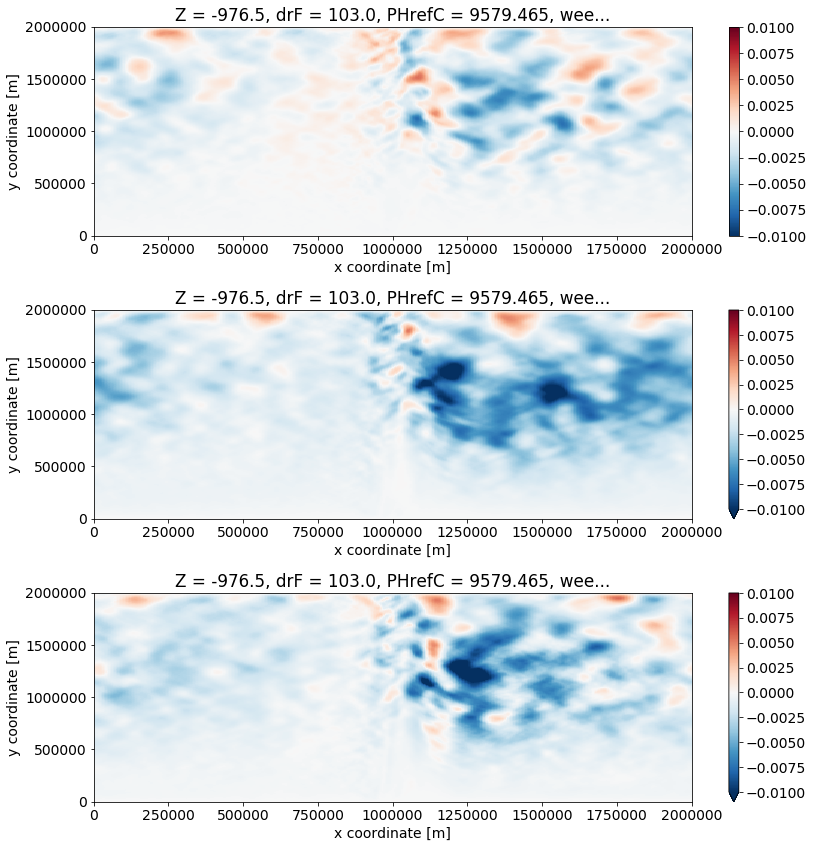

In [1618]:
plt.figure(figsize=(12,12))

plt.subplot(321)
vpcp_bar.sel(Z=-1000, method='nearest').isel(weeks=0).plot(vmin=-0.01)

plt.subplot(322)
trac_clim

plt.subplot(312)
vpcp_bar.sel(Z=-1000, method='nearest').isel(weeks=2).plot(vmin=-0.01)

plt.subplot(313)
vpcp_bar.sel(Z=-1000, method='nearest').isel(weeks=5).plot(vmin=-0.01)


plt.tight_layout()

plt.savefig('vpcp_5km.pdf', dpi=50)

In [1619]:
2

2

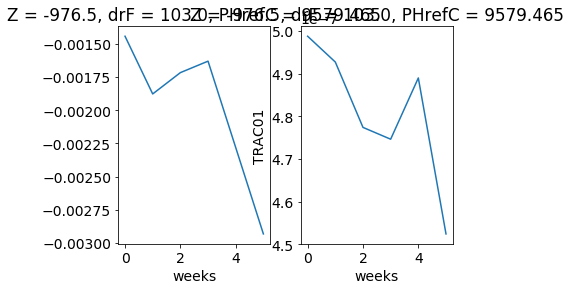

In [1620]:

plt.subplot(121)
vpcp_bar.sel(XC=slice(50,150e3), YG=slice(950e3,1050e3)).sel(Z=-1000, method='nearest').mean(['XC','YG']).plot()

plt.subplot(122)
cgrad.plot()

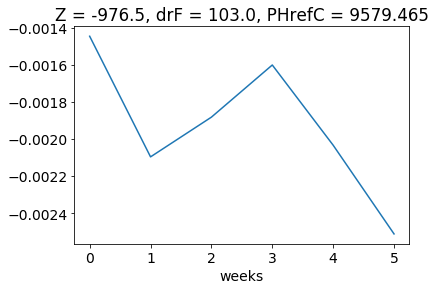

In [1617]:
vpcp_bar.sel(XC=slice(0,200e3), YG=slice(900e3,1100e3)).sel(Z=-1000, method='nearest').mean(['XC','YG']).plot()

In [1614]:
cgrad = (trac_clim.sel(Z=-1000, method='nearest').sel(XC=slice(0,100e3)).sel(YC=slice(1000e3,1100e3)).mean(['XC','YC']) - 
         trac_clim.sel(Z=-1000, method='nearest').sel(XC=slice(0,100e3)).sel(YC=slice(900e3,1000e3)).mean(['XC','YC']))/100e3

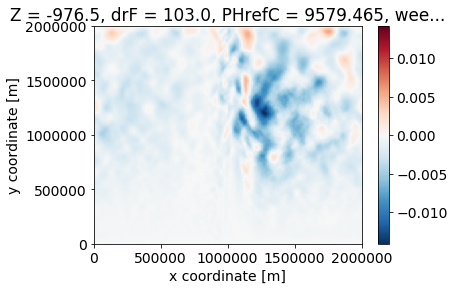

In [1599]:
vpcp_bar.sel(Z=-1000, method='nearest').isel(weeks=5).plot()

Some spatial maps of what the VC looks like in a mean sense. What is the spatial structure that is present.  

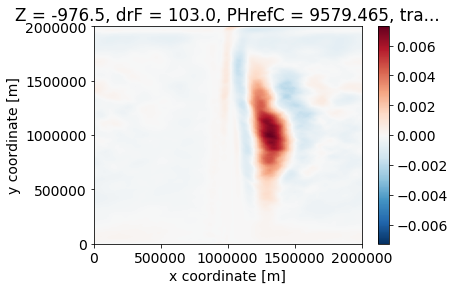

In [777]:
# does 
plt.figure(figsize=(18,4))

plt.subplot(121)
UpCp.sel(Z=-1000, method='nearest', tracer_num=1).plot()

It seems that the tracer fluxes are known to within 1% of their true values (5-10% for vertical flux) in 20 years. This implies, that it might not be required to do a spatial averaging on the data. 

# Mean picture of the tracers

In [813]:
# Tracers for 3D setup (with ridge in the middle.)
#C1 = yg/Lx
#C2 = (-zg)/H
#C3 = xg/Lx
#C4 = np.cos(np.pi*yg/Lx)  *np.cos(np.pi*zg/H)  *np.cos(np.pi*xg/Lx)
#C5 = np.sin(np.pi*yg/Lx)  *np.sin(np.pi*zg/H)  *np.sin(np.pi*xg/Lx)
#C6 = np.sin(np.pi*yg/Lx)  *np.sin(2*np.pi*zg/H)*np.sin(np.pi*xg/Lx)
#C7 = np.cos(2*np.pi*yg/Lx)*np.cos(np.pi*zg/H)*np.cos(np.pi*xg/Lx)
#C8 = np.sin(np.pi*yg/Lx)*np.sin(np.pi*zg/H)*np.sin(2*np.pi*xg/Lx)
#C9 = np.cos(2*np.pi*yg/Lx)*np.cos(2*np.pi*zg/H)*np.cos(2*np.pi*xg/Lx)
#C10 = np.sin(2*np.pi*yg/Lx)*np.sin(2*np.pi*zg/H)*np.sin(2*np.pi*xg/Lx)

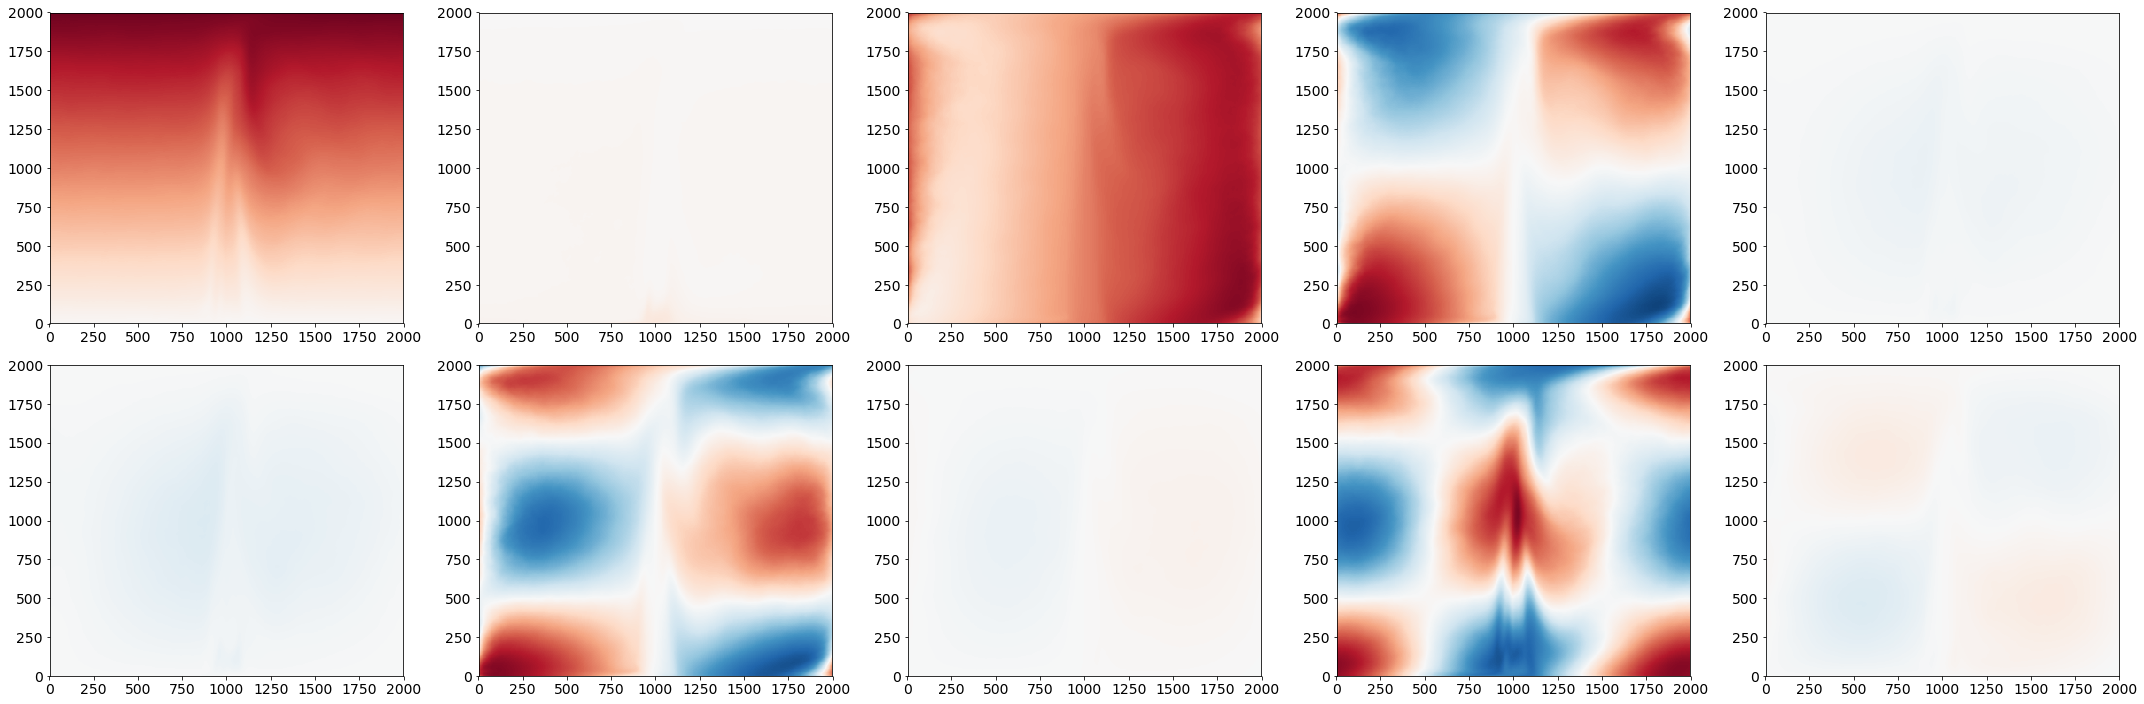

In [808]:
fig = plt.figure(figsize=(30,10))
n=0
for key in list_tracers: 
    fig.add_subplot(2,5,1+n)
    plt.pcolormesh(X/1e3, Y/1e3, tav_trac[key].sel(Z=0, method='nearest'),
                   vmin=-1, vmax=1, cmap='RdBu_r')
    n+=1
plt.tight_layout()

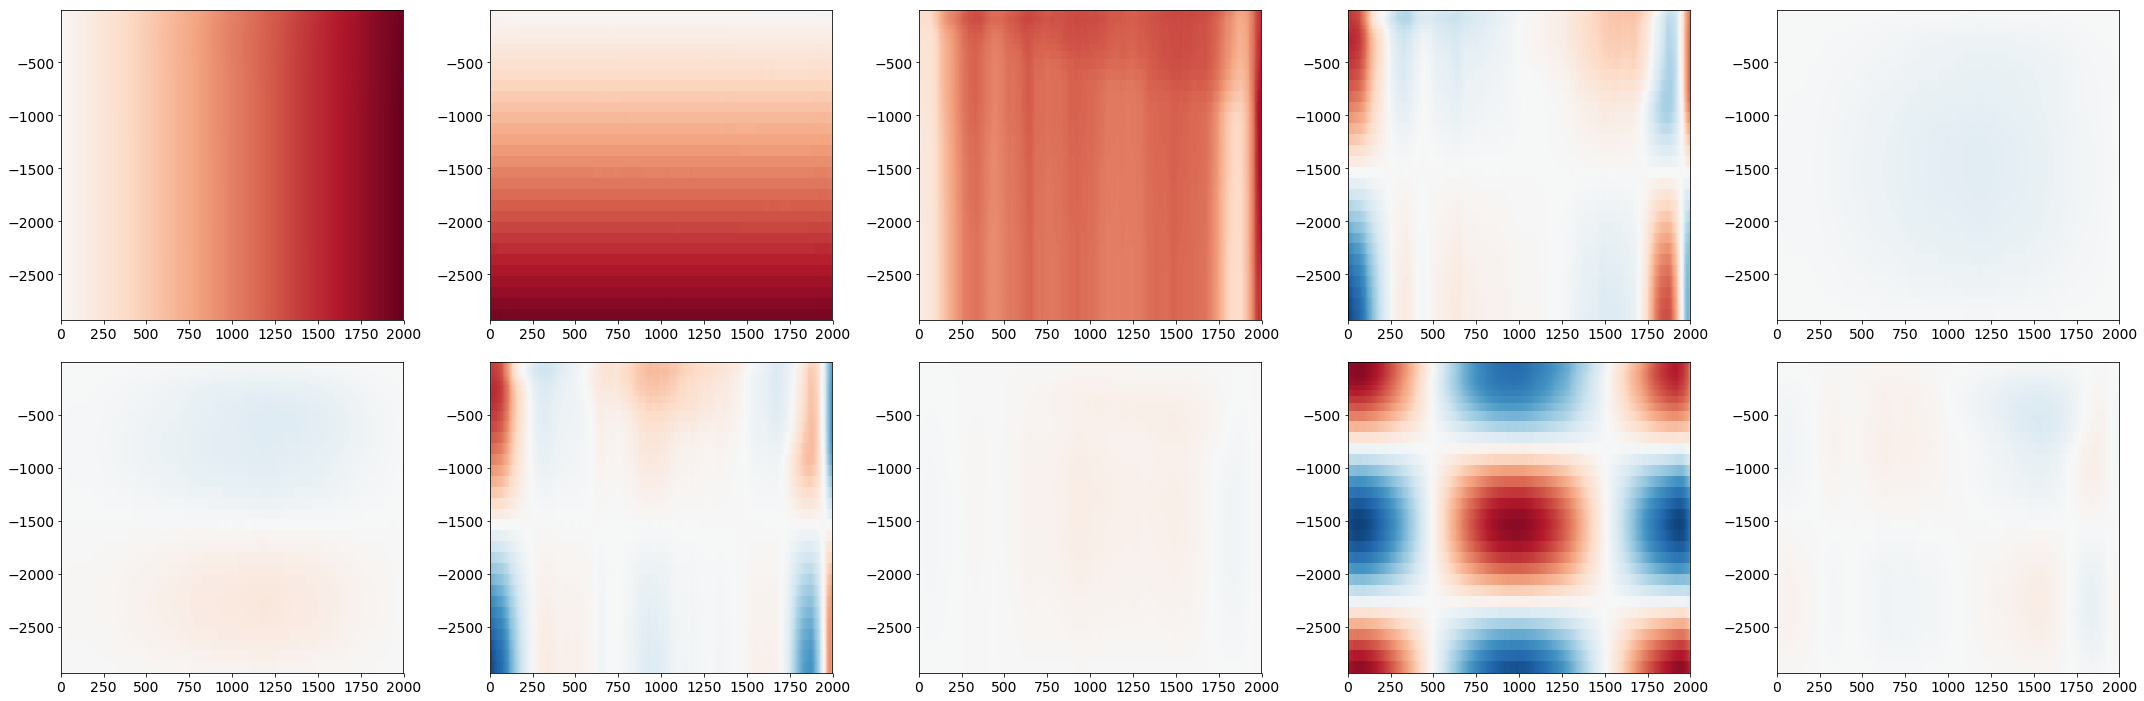

In [810]:
fig = plt.figure(figsize=(30,10))
n=0
for key in list_tracers: 
    fig.add_subplot(2,5,1+n)
    plt.pcolormesh(X/1e3, Z, tav_trac[key].sel(XC=50, method='nearest'),
                   vmin=-1, vmax=1, cmap='RdBu_r')
    n+=1
plt.tight_layout()

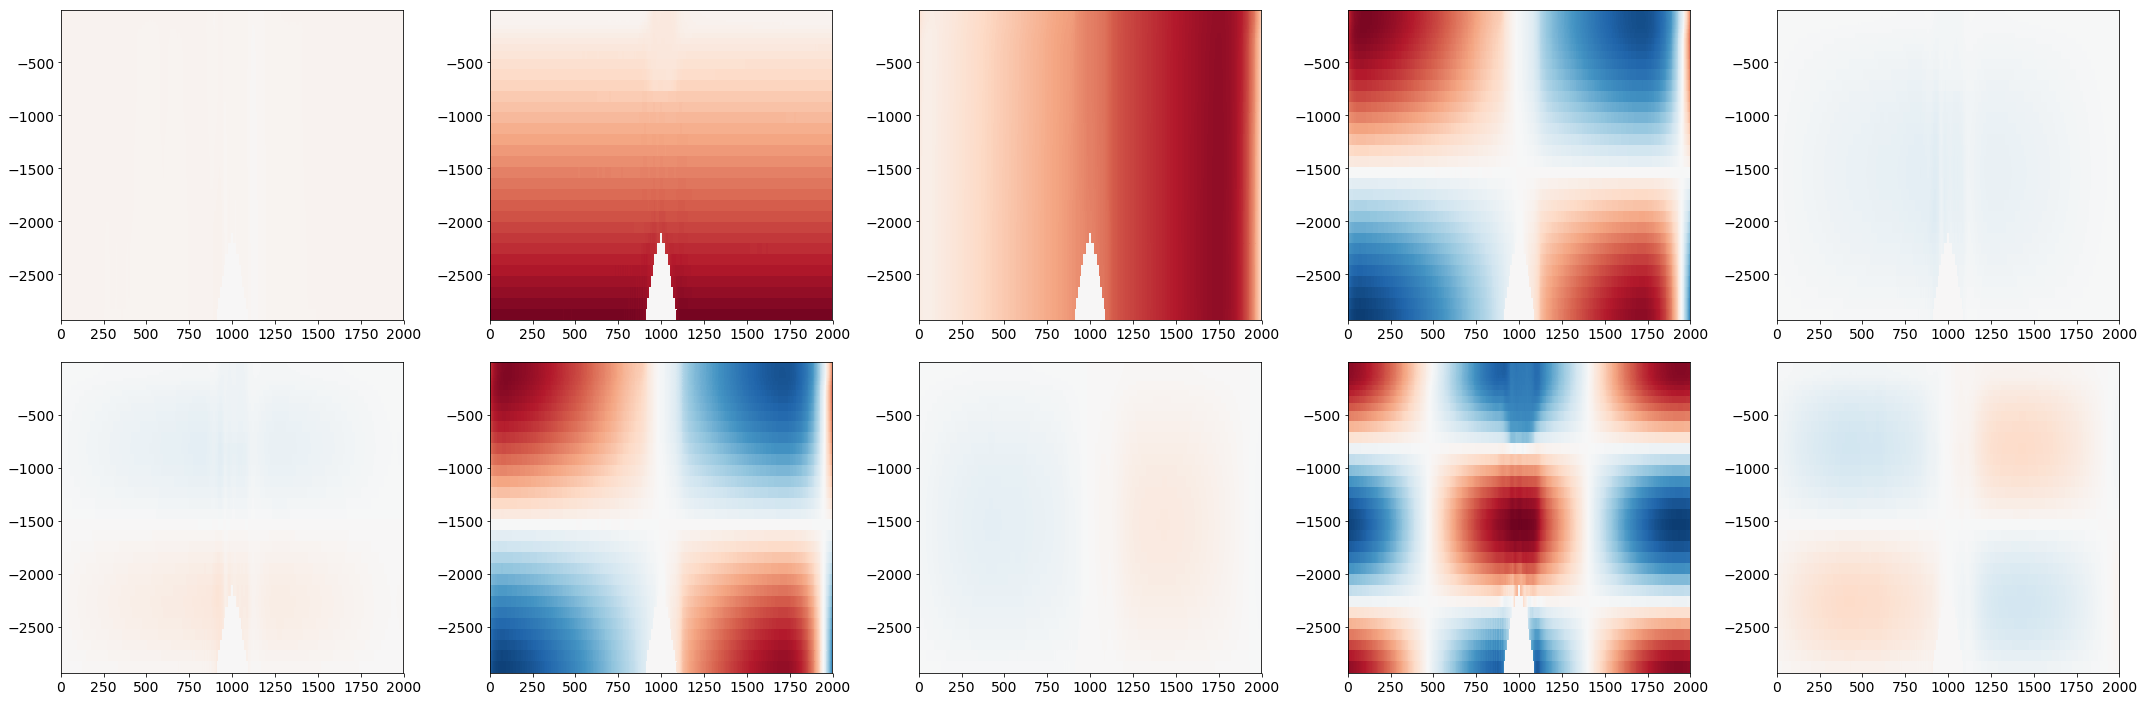

In [812]:
fig = plt.figure(figsize=(30,10))
n=0
for key in list_tracers: 
    fig.add_subplot(2,5,1+n)
    plt.pcolormesh(X/1e3, Z, tav_trac[key].sel(YC=50e3, method='nearest'),
                   vmin=-1, vmax=1, cmap='RdBu_r')
    n+=1
plt.tight_layout()

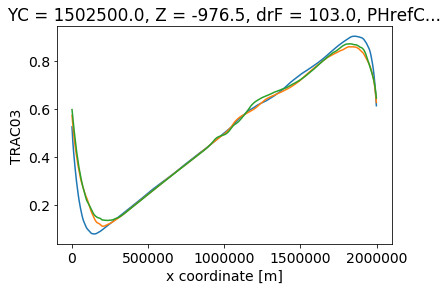

In [1379]:
tav_trac['TRAC03'].sel(Z=-1000, YC=500e3, method='nearest').plot()
tav_trac['TRAC03'].sel(Z=-1000, YC=1000e3, method='nearest').plot()
tav_trac['TRAC03'].sel(Z=-1000, YC=1500e3, method='nearest').plot()


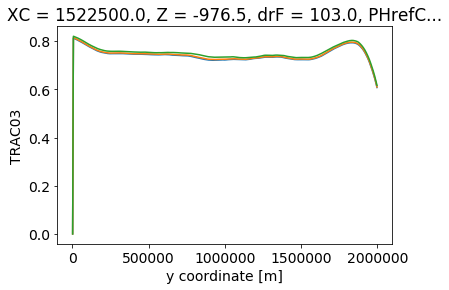

In [1383]:
tav_trac['TRAC03'].sel(Z=-1000, XC=1500e3, method='nearest').plot()
tav_trac['TRAC03'].sel(Z=-1000, XC=1505e3, method='nearest').plot()
tav_trac['TRAC03'].sel(Z=-1000, XC=1520e3, method='nearest').plot()


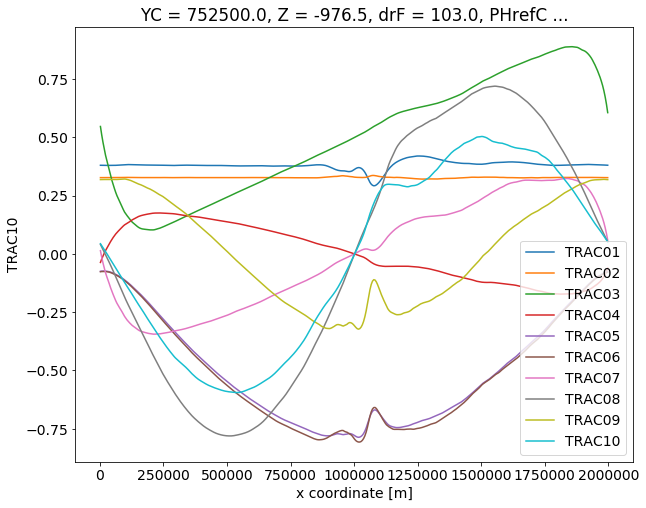

In [1486]:
plt.figure(figsize=(10,8))
for key in list_tracers:
    tav_trac[key].sel(Z=-1000, YC=750e3, method='nearest').plot()
plt.legend(list_tracers)

# Pseudo inversion to calculate the diffusivity

Here we want to invert the following equation 

\begin{equation} 
\overline{\mathbf{u}'c'} = - \mathbf{K} \nabla C
\end{equation}



In [ ]:
# Grid variable to calculate interpolations and derivatives
grid = Grid(ds_model, periodic='X')

# Some lists that will be used later for looping over variables.
list_tracers = ['TRAC01', 'TRAC02','TRAC03','TRAC04','TRAC05','TRAC06','TRAC07','TRAC08','TRAC09','TRAC10']
list_vels = ['uVeltave','vVeltave','wVeltave']
vels = {'uVeltave':'U', 'vVeltave':'V', 'wVeltave':'W'}

In [ ]:
# Calculate Ubar Cbar
# will be used to estimate the u'c' = (uc - UbarCbar)

UtavCtav = {}

for k in list_tracers:
    print(k)
    temp = {}
    for j in list_vels:
        
        if j == 'uVeltave':
            temp[j] = grid.interp(,'X')*tav_trac[k]
        
        elif j == 'vVeltave':
            temp[j] = grid.interp(Model_tav[j],'Y', boundary='extend')*tav_trac[k]
        
        elif j == 'wVeltave':
            temp[j] = grid.interp(Model_tav[j], 'Z', boundary='extend')*tav_trac[k]
            
    UtavCtav[k] = copy.deepcopy(temp)

In [ ]:
# UpCp = UC_tav - Utav*Ctav

UpCp_tav = {}

for k in list_tracers: 
    print (k)
    temp = {}
    for j in list_vels:
        if j == 'uVeltave':
            temp[j] = grid.interp(tav_trac[vels[j]+k],'X') - UtavCtav[k][j]
        elif j == 'vVeltave':
            temp[j] = grid.interp(tav_trac[vels[j]+k],'Y',boundary='extend') - UtavCtav[k][j]
        elif j == 'wVeltave':
            temp[j] = tav_trac[vels[j]+k] - UtavCtav[k][j]
            
    UpCp_tav[k] = copy.deepcopy(temp)

In [186]:
# load variables into memory for faster exectuion. 
for k in list_tracers: 
    temp = {}
    for j in list_vels:
        UpCp_tav[k][j].load()

TRAC01
TRAC02
TRAC03
TRAC06
TRAC07
TRAC08
TRAC09
TRAC10


In [ ]:
# Calculate tracer gradients 
# Tracer gradients of time averaged fields.

tav_trac_grads = {}

for k in list_tracers:
    tav_trac_grads[k] = tracer_grads(tav_trac[k], ds)

In [187]:
# load gradients into memory for faster execution.
for k in list_tracers:
    tav_trac_grads[k].load()

TRAC01
TRAC02
TRAC03
TRAC06
TRAC07
TRAC08
TRAC09
TRAC10


In [ ]:
# Define X,Y,Z for easy access. 

X = tav_trac_grads['TRAC01']['dcdx'].XC
Y = tav_trac_grads['TRAC01']['dcdx'].YC
Z = tav_trac_grads['TRAC01']['dcdx'].Z

In [301]:
# Instead of keeping different tracer fluxes in dicitionaries, 
# we would like to put them into an xarray. This will help vectorize calculations
# and also easy in plotting. 

# Put fluxes into xarrays
# U'C'
testxr1 = UpCp_tav['TRAC01']['uVeltave']
testxr1['tracer_num'] = 1

UpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = UpCp_tav[i]['uVeltave']
    temp['tracer_num'] = n 
    n=n+1
    
    UpCp = xr.concat([UpCp, temp], dim='tracer_num')

# V'C'
testxr1 = UpCp_tav['TRAC01']['vVeltave']
testxr1['tracer_num'] = 1

VpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = UpCp_tav[i]['vVeltave']
    temp['tracer_num'] = n 
    n=n+1
    
    VpCp = xr.concat([VpCp, temp], dim='tracer_num')
    
# W'C'
testxr1 = UpCp_tav['TRAC01']['wVeltave']
testxr1['tracer_num'] = 1

WpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = UpCp_tav[i]['wVeltave']
    temp['tracer_num'] = n 
    n=n+1
    
    WpCp = xr.concat([WpCp, temp], dim='tracer_num')    

In [348]:
# Put tracer gradients into xarrays
# dCdx
testxr1 = tav_trac_grads['TRAC01']['dcdx']
testxr1['tracer_num'] = 1

dCdx = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = tav_trac_grads[i]['dcdx']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdx = xr.concat([dCdx, temp], dim='tracer_num')
    
# dCdy
testxr1 = tav_trac_grads['TRAC01']['dcdy']
testxr1['tracer_num'] = 1

dCdy = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = tav_trac_grads[i]['dcdy']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdy = xr.concat([dCdy, temp], dim='tracer_num')   
    
# dCdz
testxr1 = tav_trac_grads['TRAC01']['dcdz']
testxr1['tracer_num'] = 1

dCdz = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = tav_trac_grads[i]['dcdz']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdz = xr.concat([dCdz, temp], dim='tracer_num')       

In [389]:
# Function to calculate the diffusivity tensor 

def calc_tensor(uc,vc,wc, cx,cy,cz):
    Aflux = np.array([uc, vc, wc])
    Agrad = np.array([cx, cy, cz])


    if ~(np.isnan(Agrad).any() | np.isnan(Aflux).any()):
        return -(Aflux.dot(pinv(Agrad)))
    else:
        return np.nan*(Aflux.dot(Agrad.T))

In [1239]:
# Check if the calc_tensor output is R or R^T

testgrad = np.array([[0,0,1], [0,1,1], [1,0,0]])
testgrad


array([[0, 0, 1],
       [0, 1, 1],
       [1, 0, 0]])

In [1240]:
testR = np.array([[0,1,2], [3,4,5], [6,7,8] ])
testR

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [1241]:
testflux = np.matmul(-testR, testgrad)
testflux

array([[ -2,  -1,  -1],
       [ -5,  -4,  -7],
       [ -8,  -7, -13]])

In [1242]:
testR[0]

array([0, 1, 2])

In [1243]:
calctesttensor = calc_tensor(testflux[0], testflux[1], testflux[2], testgrad[0], testgrad[1], testgrad[2])
calctesttensor

array([[-2.22044605e-16,  1.00000000e+00,  2.00000000e+00],
       [ 3.00000000e+00,  4.00000000e+00,  5.00000000e+00],
       [ 6.00000000e+00,  7.00000000e+00,  8.00000000e+00]])

In [1245]:
testgradxr = xr.DataArray(testgrad, dims=['dir','trac'])

In [1246]:
testfluxxr = xr.DataArray(testflux, dims=['dir','trac'])

In [1247]:
testKtensor = xr.apply_ufunc(calc_tensor, 
                       testfluxxr.isel(dir=0),
                       testfluxxr.isel(dir=1),
                       testfluxxr.isel(dir=2),
                       testgradxr.isel(dir=0),
                       testgradxr.isel(dir=1),
                       testgradxr.isel(dir=2),
                       input_core_dims=[['trac'], ['trac'], ['trac'], ['trac'], ['trac'], ['trac']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

In [1253]:
testKtensor.isel(i=1, j=0)

<xarray.DataArray ()>
array(3., dtype=float32)

In [458]:
# Do some chunking so that dask might be able to speed up calculations 

UpCp = UpCp.chunk({'Z':2,'XC':20})
VpCp = VpCp.chunk({'Z':2,'XC':20})
WpCp = WpCp.chunk({'Z':2,'XC':20})

dCdx = dCdx.chunk({'Z':2,'XC':20})
dCdy = dCdy.chunk({'Z':2,'XC':20})
dCdz = dCdz.chunk({'Z':2,'XC':20})

In [469]:
%%time 

# Save flux variables into netcdf files 
# here we reload them to memory to check if it helps speed up 
# (based on a hint in xarray manual)
UpCp.to_netcdf('UpCp.nc')
UpCp = xr.open_dataarray('UpCp.nc', chunks={'Z':2})

VpCp.to_netcdf('VpCp.nc')
VpCp = xr.open_dataarray('VpCp.nc', chunks={'Z':2})

WpCp.to_netcdf('WpCp.nc')
WpCp = xr.open_dataarray('WpCp.nc', chunks={'Z':2})

dCdx.to_netcdf('dcdx.nc')
dCdx = xr.open_dataarray('dcdx.nc', chunks={'Z':2})

dCdy.to_netcdf('dcdy.nc')
dCdy = xr.open_dataarray('dcdy.nc', chunks={'Z':2})

dCdz.to_netcdf('dcdz.nc')
dCdz = xr.open_dataarray('dcdz.nc', chunks={'Z':2})

CPU times: user 59.1 s, sys: 27.9 s, total: 1min 26s
Wall time: 1min 29s


(-0.005, 0.001)

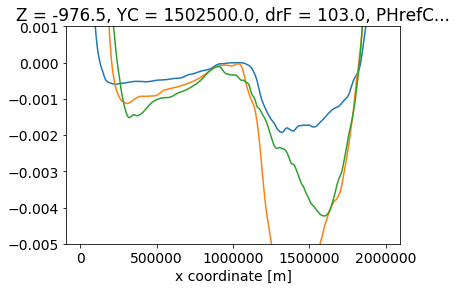

In [1387]:
UpCp.isel(tracer_num=2).sel(Z=-1000, YC=500e3, method='nearest').plot()
UpCp.isel(tracer_num=2).sel(Z=-1000, YC=1000e3, method='nearest').plot()
UpCp.isel(tracer_num=2).sel(Z=-1000, YC=1500e3, method='nearest').plot()
plt.ylim([-5e-3, 1e-3])

(-0.005, 0.001)

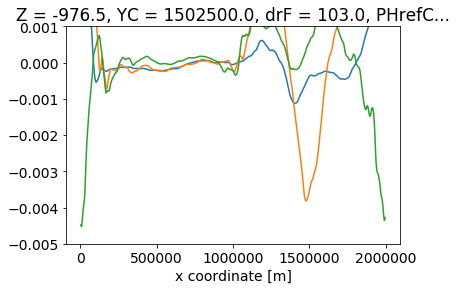

In [1487]:
VpCp.isel(tracer_num=2).sel(Z=-1000, YC=500e3, method='nearest').plot()
VpCp.isel(tracer_num=2).sel(Z=-1000, YC=1000e3, method='nearest').plot()
VpCp.isel(tracer_num=2).sel(Z=-1000, YC=1500e3, method='nearest').plot()
plt.ylim([-5e-3, 1e-3])

(-1e-06, 1e-06)

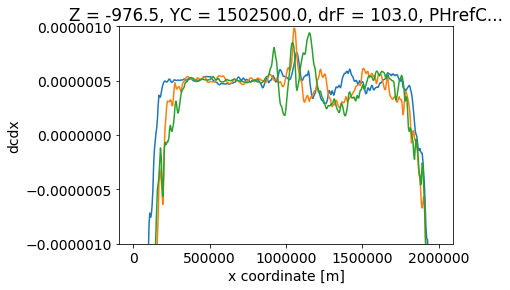

In [1392]:
dCdx.isel(tracer_num=2).sel(Z=-1000, YC=500e3, method='nearest').plot()
dCdx.isel(tracer_num=2).sel(Z=-1000, YC=1000e3, method='nearest').plot()
dCdx.isel(tracer_num=2).sel(Z=-1000, YC=1500e3, method='nearest').plot()

plt.ylim([-1e-6, 1e-6])

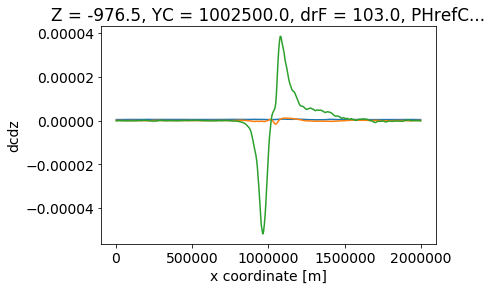

In [1494]:
dCdy.isel(tracer_num=0).sel(Z=-1000, YC=1000e3, method='nearest').plot()
dCdx.isel(tracer_num=0).sel(Z=-1000, YC=1000e3, method='nearest').plot()


In [611]:
# Calculate the tensor
# This is slow (can take over an hour)

%%time

Ktensor = xr.apply_ufunc(calc_tensor, 
                       UpCp,
                       VpCp,
                       WpCp,
                       dCdx,
                       dCdy,
                       dCdz,
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor.load() # need to load because we will take transpose and add 

CPU times: user 1.22 s, sys: 623 ms, total: 1.84 s
Wall time: 2.06 s


In [1188]:
Ktensor.to_netcdf('Ktensor_5km.nc')

In [ ]:
# split into symmetric and asymmetric parts 

KtensorT = Ktensor.transpose('Z','YC','XC','j','i') 

ST = 0.5*(Ktensor.data + KtensorT.data)
AT = 0.5*(Ktensor.data - KtensorT.data)

ST = xr.DataArray(ST, coords=Ktensor.coords, dims=Ktensor.dims)
AT = xr.DataArray(AT, coords=Ktensor.coords, dims=Ktensor.dims)

In [ ]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsST, eigvecsST = xr.apply_ufunc(eig, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [987]:
def sort_ev(x, xvec):
    xreal = x.real
    y = np.abs(xreal)
    if not np.isnan(y).any():
        z = y.argsort(axis=-1)
        return xreal[z.data], xvec[:,z.data]
    else:
        return xreal, xvec

In [992]:
# the eigenvectors have been arranged based on their magnitudes, while we want to arrange based on absolute magnitude
# so we need to resort 
evalsST, evecsST = xr.apply_ufunc(sort_ev, eigvalsST, eigvecsST, input_core_dims=[['ii'],['k','ii']]
                       , output_core_dims=[['ii'],['k','ii']], vectorize=True)
# now the eigenvalues are arranged from smallest to largest. 

In [1006]:
# get psi1, 2 and 3 

psi1 = (AT[:,:,:,1,2])
psi2 = (-AT[:,:,:,0,2])
psi3 = (AT[:,:,:,0,1])

In [ ]:
# Set psi3 to zero in a reduced tensor
AT_reduce = AT.data.copy()
AT_reduce[:,:,:,0,1] = 0. 
AT_reduce[:,:,:,1,0] = 0. 
AT_reduce = xr.DataArray(AT_reduce, coords=Ktensor.coords, dims=Ktensor.dims)

In [ ]:
# Calculate the eigen values of the reduced tensor
eigvalsAT_reduce, eigvecsAT_reduce = xr.apply_ufunc(eig, AT_reduce, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [ ]:
# Calculate the isopycnal slopes
Tgrad = tracer_grads(Model_tav.Ttave, ds_model)

S_x = - Tgrad['dcdx']/Tgrad['dcdz']
S_y = - Tgrad['dcdy']/Tgrad['dcdz']
S_mag = (S_x**2 + S_y**2)**0.5

S_x.load()
S_y.load()
S_mag.load()


In [815]:
# Gm diffusivity 
Kgm = np.abs(eigvalsAT_reduce).max('ii')/S_mag
Kgm_approx = np.abs(eigvalsAT_reduce).max('ii')/(S_mag.sel(Z=slice(-500,-2000)).mean('Z'))

2

# Figures of diffusivities and eigen vectors below this 

## 1st eigenvalue of Symmetric tensor

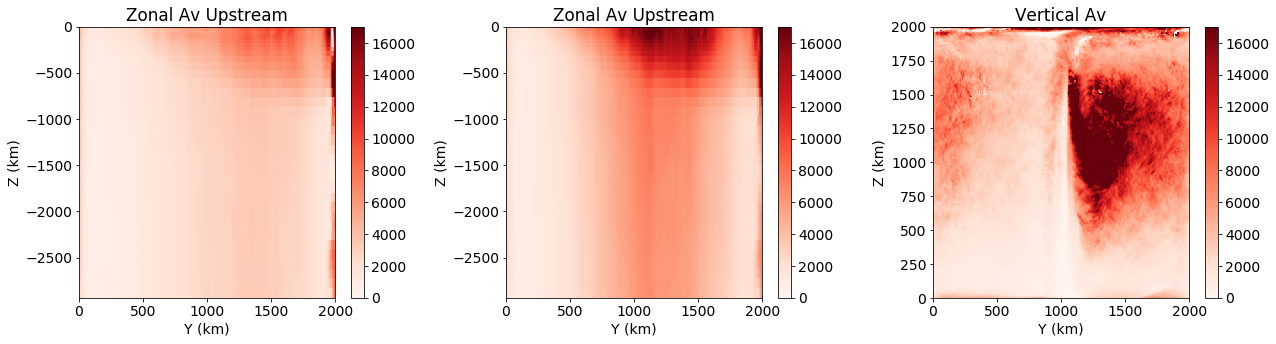

In [993]:
# Averaged plots 

fig = plt.figure(figsize = (18,5))

fig.add_subplot(131)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=2)*ds_model.hFacC).sel(XC=slice(0,800e3)).mean('XC'), vmin=0, vmax=17000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(132)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=2)*ds_model.hFacC).sel(XC=slice(1200,2000e3)).mean('XC'), vmin=0, vmax=17000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(133)
plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=2)*ds_model.hFacC).mean('Z'), vmin=0, vmax=17000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Vertical Av')
plt.colorbar()

plt.tight_layout()

## 2nd eigen value of Symmetric Tensor

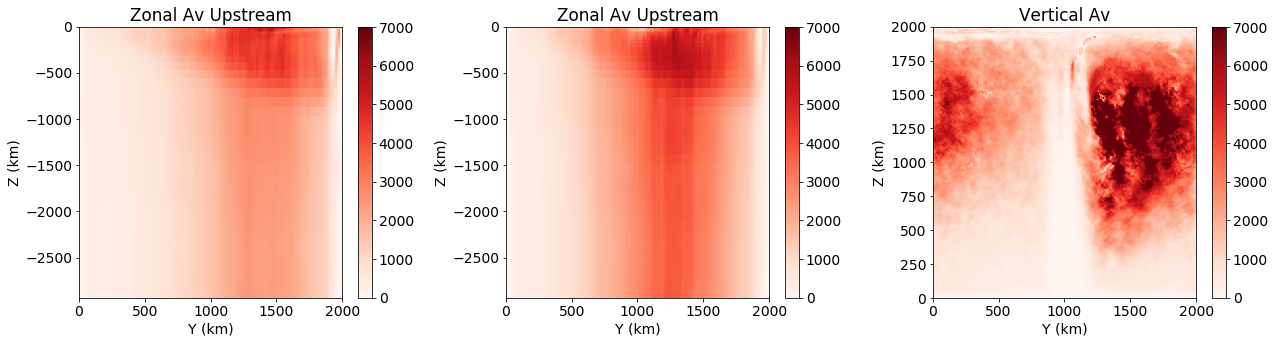

In [998]:
# Averaged plots 

fig = plt.figure(figsize = (18,5))

fig.add_subplot(131)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=1)*ds_model.hFacC).sel(XC=slice(0,800e3)).mean('XC'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(132)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=1)*ds_model.hFacC).sel(XC=slice(1200,2000e3)).mean('XC'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(133)
plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=1)*ds_model.hFacC).mean('Z'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Vertical Av')
plt.colorbar()

plt.tight_layout()
#plt.savefig('Kredi_5km_res.pdf', dpi=50)


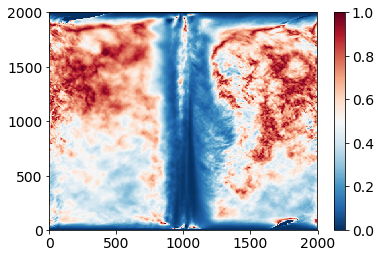

In [1176]:
# ratio 

plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=1)/evalsST.isel(ii=2)).sel(Z=-1000, method='nearest'),
               vmin=0, vmax=1, cmap='RdBu_r')
plt.colorbar()


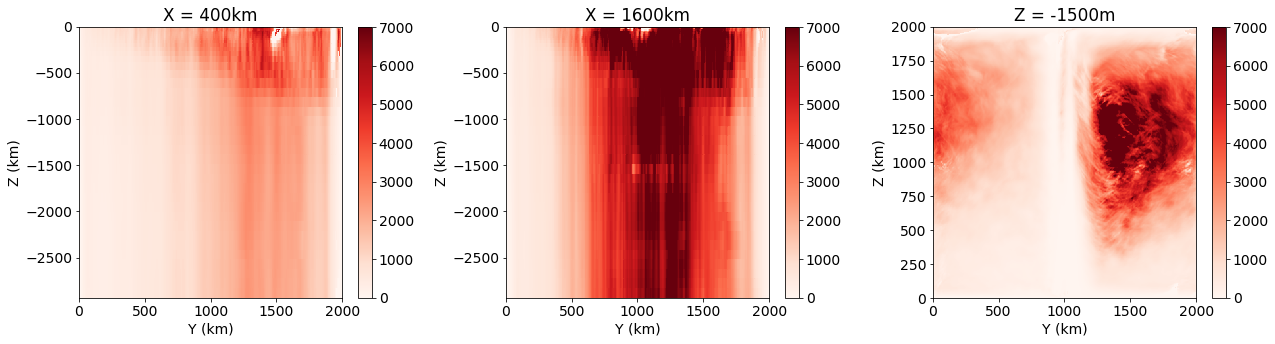

In [994]:
# Section plots 

fig = plt.figure(figsize = (18,5))

fig.add_subplot(131)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=1)*ds_model.hFacC).sel(XC=400e3, method='nearest'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('X = 400km')
plt.colorbar()

fig.add_subplot(132)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=1)*ds_model.hFacC).sel(XC=1600e3, method='nearest'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('X = 1600km')
plt.colorbar()

fig.add_subplot(133)
plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=1)*ds_model.hFacC).sel(Z=-1500, method='nearest'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Z = -1500m')
plt.colorbar()

plt.tight_layout()


# 3rd eigenvalue of Symmetric Tensor 
 
** the patchy structure observed here results from the  eigenvalues not being arranged perfectly, can be fixed easily. This is also the reason for some off points in the previous plots. **

What fraction of the strong "diapycnal" diffusivity is noise, vs true diapycnal transfer across mean isopycnals?

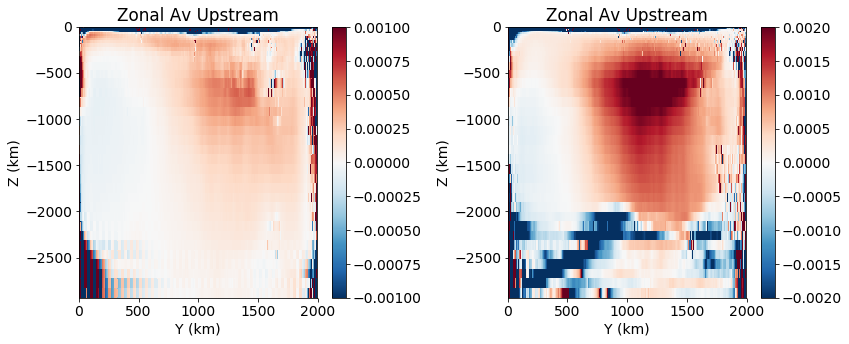

In [997]:
# Averaged plots 

fig = plt.figure(figsize = (12,5))

fig.add_subplot(121)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=0)*ds_model.hFacC).sel(XC=slice(0,800e3)).mean('XC'), vmin=-1e-3, vmax=1e-3,   cmap='RdBu_r')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(122)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=0)*ds_model.hFacC).sel(XC=slice(1400,1800e3)).mean('XC'),  vmin=-2e-3, vmax=2e-3, cmap='RdBu_r')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()



plt.tight_layout()
#plt.savefig('Kredi_5km_res.pdf', dpi=50)

# How well do the diagnosed tensors reproduce buoyancy eddy fluxes

\begin{equation}
E(\overline{u_i'b'}) = \frac{|\overline{u_i'b'} + R_{ij}\nabla \overline{b}|}{|\overline{u_i'b'}|} 
\end{equation}

In [1274]:
# Ktensor is R 

recUflux = Ktensor.sel(i=0, j=0)*dCdx + Ktensor.sel(i=0, j=1)*dCdy + Ktensor.sel(i=0, j=2)*dCdz
recVflux = Ktensor.sel(i=1, j=0)*dCdx + Ktensor.sel(i=1, j=1)*dCdy + Ktensor.sel(i=1, j=2)*dCdz
recWflux = Ktensor.sel(i=2, j=0)*dCdx + Ktensor.sel(i=2, j=1)*dCdy + Ktensor.sel(i=2, j=2)*dCdz

In [1275]:
errU = np.abs(UpCp + recUflux)/np.abs(UpCp)
errV = np.abs(VpCp + recVflux)/np.abs(VpCp)
errW = np.abs(WpCp + recWflux)/np.abs(WpCp)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


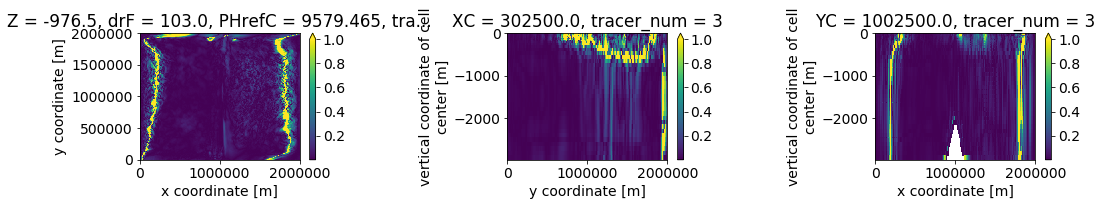

In [1273]:
fig = plt.figure(figsize=(15,3))

fig.add_subplot(131)
errU.isel(tracer_num=2).sel(Z=-1000, method='nearest').plot(vmax =1)

fig.add_subplot(132)
errU.isel(tracer_num=2).sel(XC=300e3, method='nearest').plot(vmax =1)

fig.add_subplot(133)
errU.isel(tracer_num=2).sel(YC=1000e3, method='nearest').plot(vmax =1)


plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


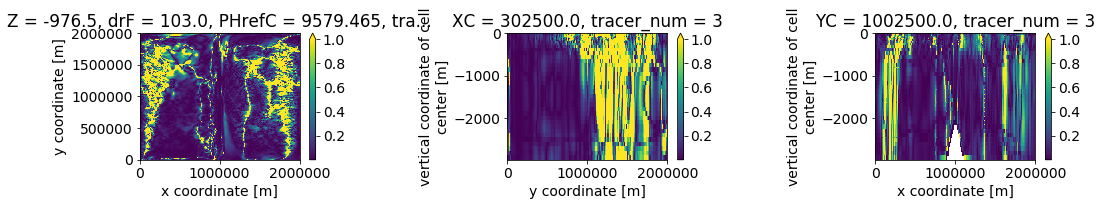

In [1276]:
fig = plt.figure(figsize=(15,3))

fig.add_subplot(131)
errV.isel(tracer_num=2).sel(Z=-1000, method='nearest').plot(vmax =1)

fig.add_subplot(132)
errV.isel(tracer_num=2).sel(XC=300e3, method='nearest').plot(vmax =1)

fig.add_subplot(133)
errV.isel(tracer_num=2).sel(YC=1000e3, method='nearest').plot(vmax =1)

plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


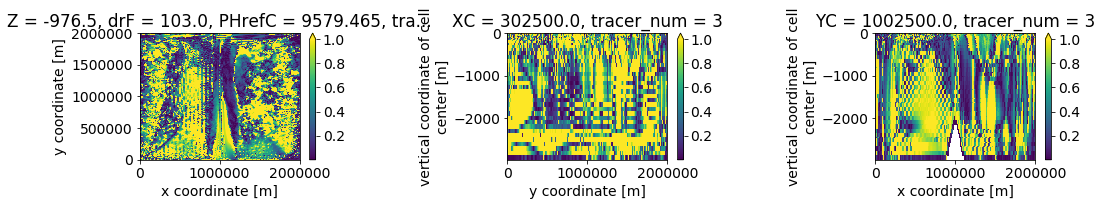

In [1277]:
fig = plt.figure(figsize=(15,3))

fig.add_subplot(131)
errW.isel(tracer_num=2).sel(Z=-1000, method='nearest').plot(vmax =1)

fig.add_subplot(132)
errW.isel(tracer_num=2).sel(XC=300e3, method='nearest').plot(vmax =1)

fig.add_subplot(133)
errW.isel(tracer_num=2).sel(YC=1000e3, method='nearest').plot(vmax =1)

plt.tight_layout()

In [1358]:
percU = np.zeros(8)
for i in range(0,8):
    A = np.array(errU.isel(tracer_num=i).data.reshape(-1))
    percU[i] = (np.percentile(A[np.argwhere(~np.isnan(A))] , 95))
    print(percU[i])

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


3.7930014729499666
26.144394683837845
0.6693664908409112
1.2018904924392686
1.028000873327255
0.7815073698759074
0.7758339524269031
1.325593143701553


In [1359]:
percV = np.zeros(8)
for i in range(0,8):
    A = np.array(errV.isel(tracer_num=i).data.reshape(-1))
    percV[i] = (np.percentile(A[np.argwhere(~np.isnan(A))] , 95))

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


In [1360]:
percW = np.zeros(8)
for i in range(0,8):
    A = np.array(errW.isel(tracer_num=i).data.reshape(-1))
    percW[i] = (np.percentile(A[np.argwhere(~np.isnan(A))] , 95))

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask-0.17.2+14.gbd9fed7-py3.5.egg/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


Text(0.5,1,'95 Percentile Relative Error')

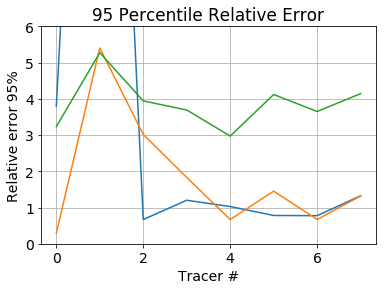

In [1365]:
plt.plot(percU)
plt.plot(percV)
plt.plot(percW)

plt.ylim([0,6])
plt.grid()
plt.xlabel('Tracer #')
plt.ylabel('Relative error 95%')
plt.title('95 Percentile Relative Error')

In [1280]:
Uflux = UpCp.sel(XC=300e3, YC=1000e3, Z=-1000, method='nearest')
Vflux = VpCp.sel(XC=300e3, YC=1000e3, Z=-1000, method='nearest')
Wflux = WpCp.sel(XC=300e3, YC=1000e3, Z=-1000, method='nearest')

In [1281]:
Xgrad = dCdx.sel(XC=300e3, YC=1000e3, Z=-1000, method='nearest')
Ygrad = dCdy.sel(XC=300e3, YC=1000e3, Z=-1000, method='nearest')
Zgrad = dCdz.sel(XC=300e3, YC=1000e3, Z=-1000, method='nearest')

In [1282]:
tens = xr.apply_ufunc(calc_tensor, 
                       Uflux,
                       Vflux,
                       Wflux,
                       Xgrad,
                       Ygrad,
                       Zgrad,
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

In [1302]:
testrecU = tens.isel(i=0, j=0)*Xgrad + tens.isel(i=0, j=1)*Ygrad + tens.isel(i=0, j=2)*Zgrad
testrecV = tens.isel(i=1, j=0)*Xgrad + tens.isel(i=1, j=1)*Ygrad + tens.isel(i=1, j=2)*Zgrad
testrecW = tens.isel(i=2, j=0)*Xgrad + tens.isel(i=2, j=1)*Ygrad + tens.isel(i=2, j=2)*Zgrad

In [1306]:
print(testrecU.data)
print(Uflux.data)
print(np.abs(testrecU+Uflux).data/np.abs(Uflux).data)

[ 2.2049302e-04  2.1036940e-05  1.0343262e-03 -2.8230038e-03
  5.9536565e-04 -3.8211348e-03 -2.3232219e-03  1.0142573e-03]
[-2.1197787e-04 -1.5579630e-05 -1.1270865e-03  2.8369713e-03
 -7.5522740e-04  3.7194998e-03  2.3904198e-03 -1.0170694e-03]
[0.04017002 0.35028496 0.08230097 0.00492339 0.21167366 0.02732491
 0.02811136 0.00276493]


In [1307]:
print(testrecV.data)
print(Vflux.data)
print(np.abs(testrecV+Vflux).data/np.abs(Vflux).data)

[ 1.4655535e-03  1.1017147e-04  8.0092803e-05 -3.7755573e-04
  3.4041138e-04 -8.4016996e-04 -2.1601448e-04  5.9129284e-03]
[-1.3710689e-03 -9.6639502e-05 -1.3420472e-04  4.1566638e-04
 -3.9937283e-04  7.8584522e-04  2.1803688e-04 -5.9376708e-03]
[0.06891313 0.14002526 0.40320426 0.09168568 0.1476351  0.06912906
 0.00927548 0.00416703]


In [1308]:
print(testrecW.data)
print(Wflux.data)
print(np.abs(testrecW+Wflux).data/np.abs(Wflux).data)

[-1.5983517e-07 -9.8078885e-08  2.6739333e-08 -1.5904477e-07
 -2.1673934e-07  7.0491367e-08 -3.3660535e-07 -6.3376012e-07]
[ 1.0923987e-07  7.6674510e-08 -6.3314857e-08  1.2584587e-07
  1.9484636e-07 -7.8252995e-08  3.6833620e-07  6.4639153e-07]
[0.4631578  0.27915895 0.57767683 0.26380605 0.11236018 0.09918634
 0.08614643 0.01954141]


In [1293]:
testU = Uflux.load().data
testV = Vflux.load().data
testW = Wflux.load().data

In [1295]:
testX = Xgrad.load().data
testY = Ygrad.load().data
testZ = Zgrad.load().data

In [1296]:
testK = calc_tensor(testU, testV, testW, testX, testY, testZ)

In [1004]:
# Define some unit vectors
i  = np.array([1., 0., 0.])
j  = np.array([0., 1., 0.])
k  = np.array([0., 0., 1.])

In [1158]:
# angle to the horizontal 

v2 = evecsST.sel(ii=1)

v3 = evecsST.sel(ii=0)

dp = np.dot(np.abs(v2),j)
alpha = np.arccos(dp)

alpha = xr.DataArray(alpha, dims = v2.sel(k=0).dims, coords= v2.sel(k=0).coords)

dp = np.dot(v2,k)
beta = np.arccos(dp)

In [1169]:
v2.sel(XC=0, YC=1000e3, Z=-1000, method='nearest')

<xarray.DataArray (k: 3)>
array([-8.532599e-01,  5.214860e-01, -3.133434e-05], dtype=float32)
Coordinates:
    Z        float32 -976.5
    YC       float32 1002500.0
    XC       float32 2500.0
    rA       float32 25000000.0
    Depth    float32 2985.0
    drF      float32 103.0
    PHrefC   float32 9579.465
    hFacC    float32 1.0
Dimensions without coordinates: k

In [1160]:
Model_tav.ET

<xarray.Dataset>
Dimensions:   (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40)
Coordinates:
  * YC        (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG        (XG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * XC        (XC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * YG        (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
    dxG       (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    rA        (YC, XC) >f4 25000000.0 25000000.0 ... 25000000.0 25000000.0
    dyC       (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    rAz       (YG, XG) >f4 2500

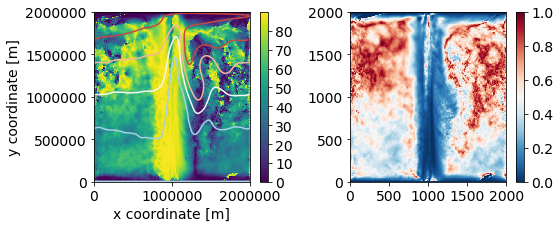

In [1178]:
plt.figure(figsize=(,3.4))

plt.subplot(121)
(alpha*180/np.pi).sel(Z=-1000, method='nearest').plot()
Model_tav.ETAtave.plot.contour()

plt.subplot(122)
plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=1)/evalsST.isel(ii=2)).sel(Z=-1000, method='nearest'),
               vmin=0, vmax=1, cmap='RdBu_r')
plt.colorbar()

plt.tight_layout()

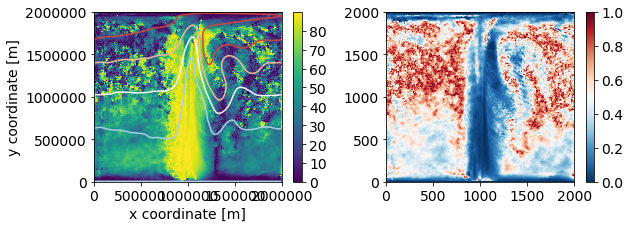

In [1180]:
plt.figure(figsize=(9,3.4))

plt.subplot(121)
(alpha*180/np.pi).sel(Z=-400, method='nearest').plot()
Model_tav.ETAtave.plot.contour()

plt.subplot(122)
plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=1)/evalsST.isel(ii=2)).sel(Z=-400, method='nearest'),
               vmin=0, vmax=1, cmap='RdBu_r')
plt.colorbar()

plt.tight_layout()

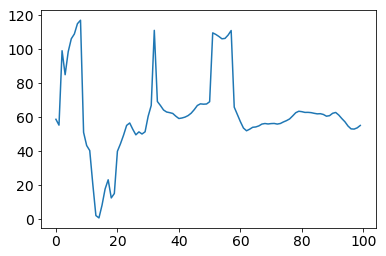

In [1132]:
plt.plot(alpha*180./np.pi)

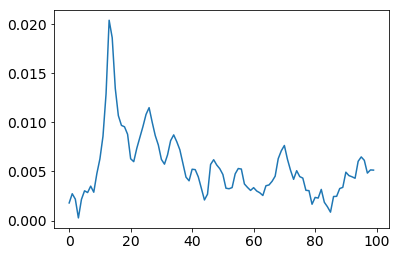

In [1150]:
plt.plot(np.abs(beta*180./np.pi-90))

In [1137]:
beta

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00048828, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
# Angle of the "vertical vector", corresponding to smallest eigval, to the horizontal direction. 



# What does the R tensor looks like 

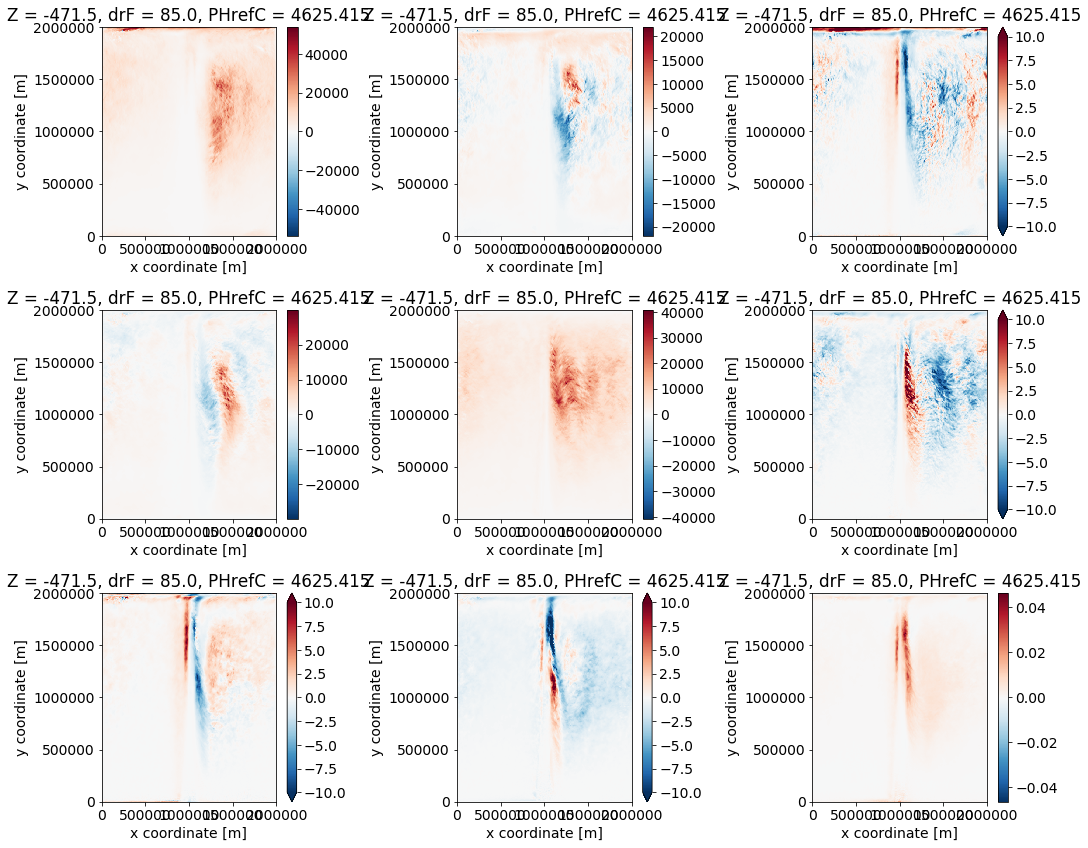

In [1370]:
fig = plt.figure(figsize=(15,12))

fig.add_subplot(331)
Ktensor.sel(Z=-500, method='nearest').isel(i=0, j=0).plot()

fig.add_subplot(332)
Ktensor.sel(Z=-500, method='nearest').isel(i=0, j=1).plot()

fig.add_subplot(333)
Ktensor.sel(Z=-500, method='nearest').isel(i=0, j=2).plot(vmin=-10)

fig.add_subplot(334)
Ktensor.sel(Z=-500, method='nearest').isel(i=1, j=0).plot()

fig.add_subplot(335)
Ktensor.sel(Z=-500, method='nearest').isel(i=1, j=1).plot()

fig.add_subplot(336)
Ktensor.sel(Z=-500, method='nearest').isel(i=1, j=2).plot(vmin=-10)

fig.add_subplot(337)
Ktensor.sel(Z=-500, method='nearest').isel(i=2, j=0).plot(vmin=-10)

fig.add_subplot(338)
Ktensor.sel(Z=-500, method='nearest').isel(i=2, j=1).plot(vmin=-10)

fig.add_subplot(339)
Ktensor.sel(Z=-500, method='nearest').isel(i=2, j=2).plot()


plt.tight_layout()

# Flow corresponding to psi 1

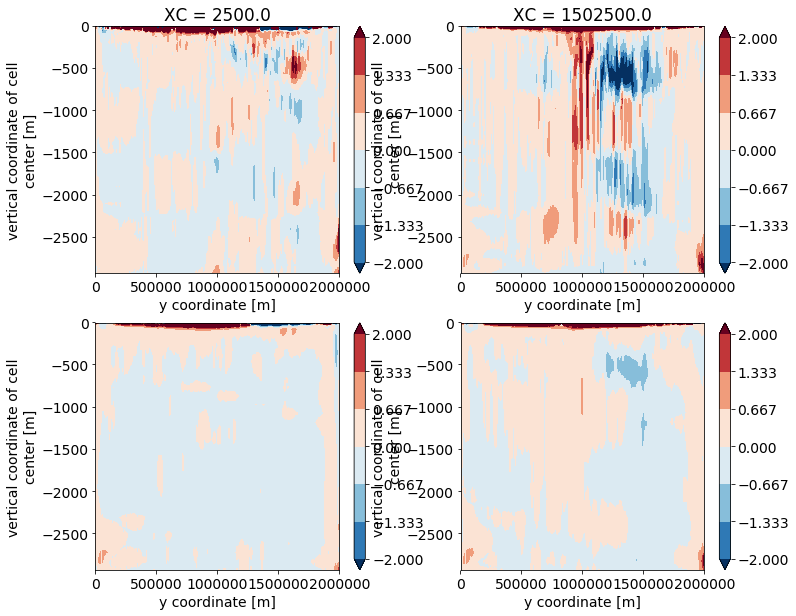

In [1186]:
fig= plt.figure(figsize=(12,10))

fig.add_subplot(221)
psi1.sel(XC=0, method='nearest').plot.contourf(vmin=-2)

fig.add_subplot(222)
psi1.sel(XC=1500e3, method='nearest').plot.contourf(vmin=-2)

fig.add_subplot(223)
psi1.sel(XC=slice(0,800e3)).mean('XC').plot.contourf(vmin=-2)

fig.add_subplot(224)
psi1.sel(XC=slice(1200e3,2000e3)).mean('XC').plot.contourf(vmin=-2)



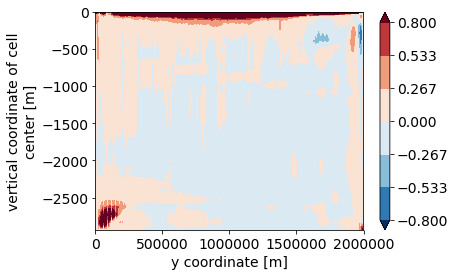

In [1185]:
psi1.sel(XC=slice(700e3,800e3)).mean('XC').plot.contourf(vmin=-0.8)

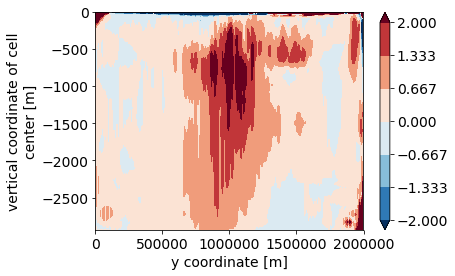

In [1100]:
psi2.sel(XC=slice(1200e3,1300e3)).mean('XC').plot.contourf(vmin=-2)

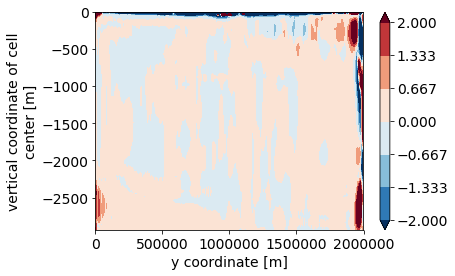

In [1181]:
psi2.sel(XC=slice(200e3,300e3)).mean('XC').plot.contourf(vmin=-2)

# Flow corresponding to psi 3 

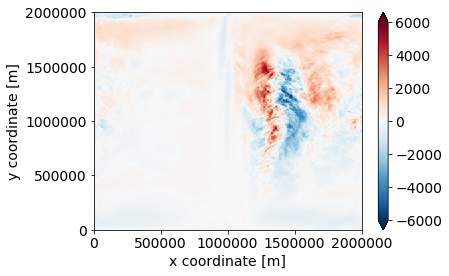

In [1024]:
psi3.sel(Z=slice(-700, -1700)).mean('Z').plot(vmin=-6000)

In [1013]:
# get velocity from psi3. 
dx = Model_tav.dxC[0,0]
Upsi3 = -grid.diff(psi3, 'Y', boundary='extend')/dx
Vpsi3 = grid.diff(psi3, 'X')/dx

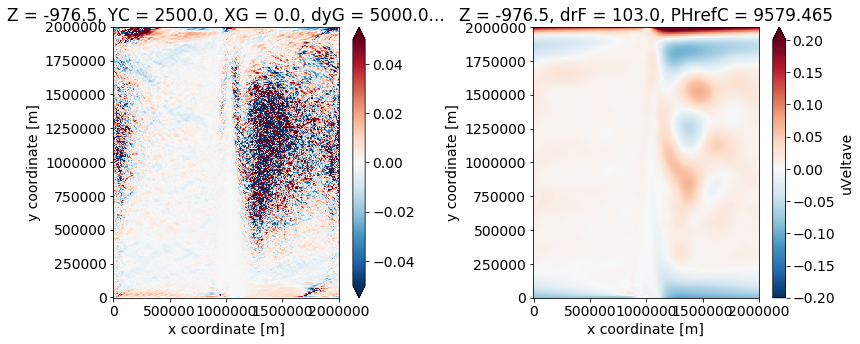

In [1021]:
fig = plt.figure(figsize=(12,5))

fig.add_subplot(121)
Upsi3.sel(Z=-1000, method='nearest').plot(vmin=-0.05)

fig.add_subplot(122)
Model_tav.uVeltave.sel(Z=-1000, method='nearest').plot(vmin=-0.2)

plt.tight_layout()

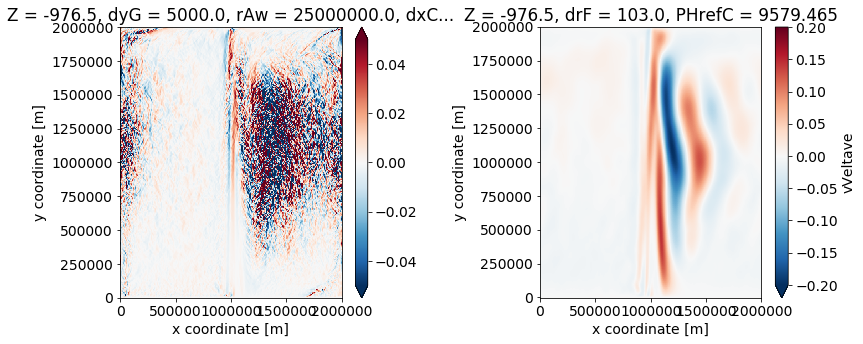

In [1022]:
fig = plt.figure(figsize=(12,5))

fig.add_subplot(121)
Vpsi3.sel(Z=-1000, method='nearest').plot(vmin=-0.05)

fig.add_subplot(122)
Model_tav.vVeltave.sel(Z=-1000, method='nearest').plot(vmin=-0.2)

plt.tight_layout()

It seems that the contribution of psi3 to the flow is small, about 10-20% of the mean flow, velocities. However, we need to do some smoothing to confirm numbers.

What might be of interest, is to confirm how psi3 aligns to geostrophic flows. If the contours are parallel, psi3 is simply a correction to mean velocity, but if psi3 is turned wrt the local geostrophic stream function it can be very important for the cross stream transport in the ACC. 

## Think about smoothing
The results here, while being very informative, are some what spatially noisy. To make better plots, and better approximate gradient quantities, it might make sense to use some sort of smoothing. Two alternatives are possible: analyze the tensor and then smooth, or smooth and then analyze. 

## Mixing Suppression

Channel models in the past have seen enhanced diffusivities at depth. For this to be the case one needs to have eddies that are advected with the mean flow. In our simulations we barely see that. 


In [1063]:
Eta_hov = ds_model.ETAtave.sel(
    YC=slice(950e3, 1150e3)).mean('YC').load()

In [1083]:
Eta_hov_1600 = ds_model.ETAtave.sel(
    YC=slice(1550e3, 1650e3)).mean('YC').load()

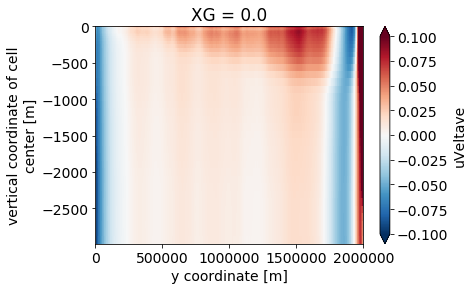

In [1082]:
Model_tav.uVeltave.sel(XG = 0, method='nearest').plot(vmin=-0.1)
plt.savefig('meanUatx0.pdf')

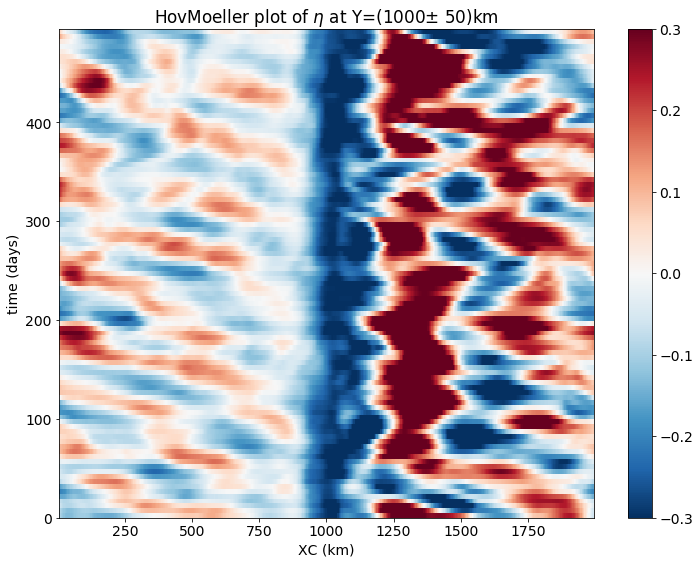

In [1069]:
plt.figure(figsize=(12,9))

tslice = slice(0,100)
plt.pcolormesh(Eta_hov.XC/1e3, Eta_hov.time.isel(time=tslice)/24/3600 - Eta_hov.time.isel(time=0)/24/3600 , 
               Eta_hov.isel(time=tslice), vmin=-0.3, vmax=0.3, cmap='RdBu_r')
plt.colorbar()
plt.xlabel('XC (km)')
plt.ylabel('time (days)')
plt.title('HovMoeller plot of $\eta$ at Y=(1000$\pm$ 50)km')

plt.savefig('Hovmoeller_eta.pdf')

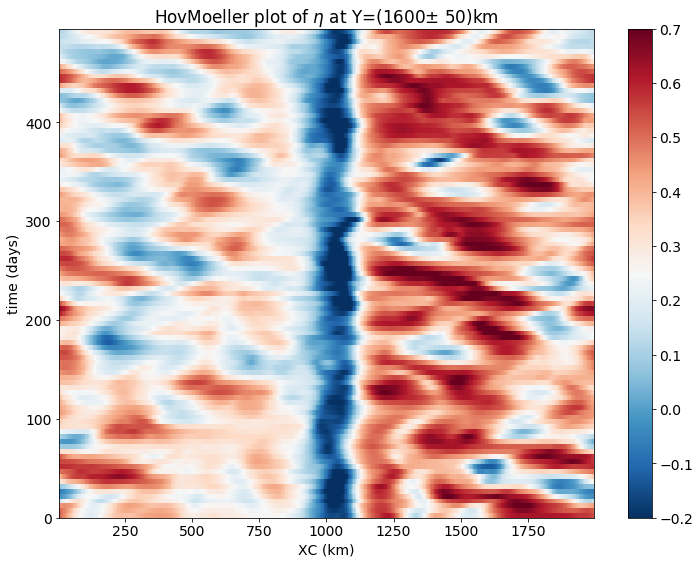

In [1088]:
plt.figure(figsize=(12,9))

tslice = slice(0,100)
plt.pcolormesh(Eta_hov.XC/1e3, Eta_hov.time.isel(time=tslice)/24/3600 - Eta_hov.time.isel(time=0)/24/3600 , 
               Eta_hov_1600.isel(time=tslice), vmin=-0.2, vmax=0.7, cmap='RdBu_r')
plt.colorbar()
plt.xlabel('XC (km)')
plt.ylabel('time (days)')
plt.title('HovMoeller plot of $\eta$ at Y=(1600$\pm$ 50)km')

plt.savefig('Hovmoeller_eta_1600.pdf')

(0, 5000.0)

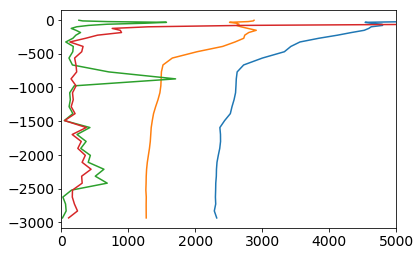

In [720]:
plt.plot((eigvalsST.isel(ii=0).real).sel(XC=500e3, YC=1000e3, method='nearest'), Z)

plt.plot((eigvalsST.isel(ii=1).real).sel(XC=500e3, YC=1000e3, method='nearest'), Z)
plt.plot((Kgm).sel(XC=500e3, YC=1000e3, method='nearest'), Z)
plt.plot((Kgm_approx).sel(XC=500e3, YC=1000e3, method='nearest'), Z)
plt.xlim([0,5e3])

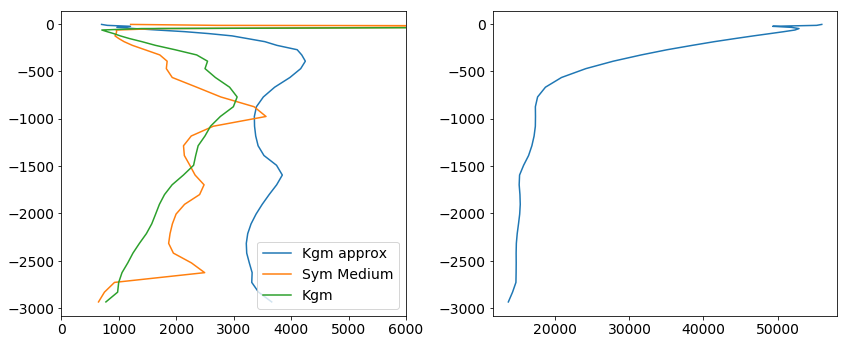

In [736]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot((eigvalsST.isel(ii=1).real).sel(XC=slice(1200e3, 1300e3), YC=slice(900e3, 1100e3)).mean(['XC','YC']), Z)
plt.plot((Kgm).sel(XC=slice(1200e3, 1300e3), YC=slice(900e3, 1100e3)).mean(['XC','YC']), Z)
plt.plot((Kgm_approx).sel(XC=slice(1200e3, 1300e3), YC=slice(900e3, 1100e3)).mean(['XC','YC']), Z)
plt.legend({'Sym Medium', 'Kgm', 'Kgm approx'})

plt.xlim([0,6e3])

plt.subplot(122)
plt.plot((eigvalsST.isel(ii=0).real).sel(XC=slice(1200e3, 1300e3), YC=slice(900e3, 1100e3)).mean(['XC','YC']), Z)

plt.tight_layout()


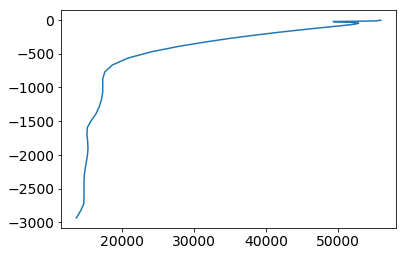

In [726]:
plt.plot((eigvalsST.isel(ii=0).real).sel(XC=slice(1200e3, 1300e3), YC=slice(900e3, 1100e3)).mean(['XC','YC']), Z)


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


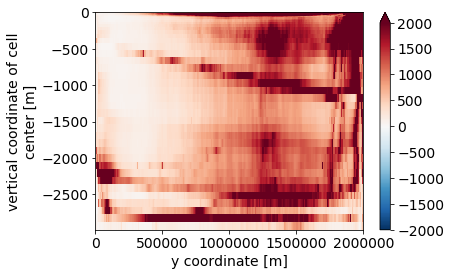

In [686]:
Kgm.mean('XC').plot(vmin=-2000, vmax=2000, cmap='RdBu_r')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


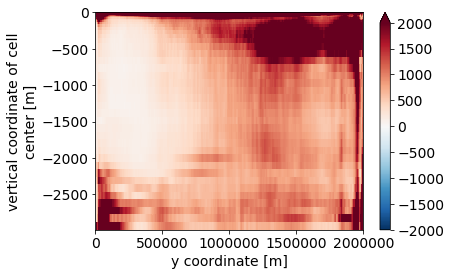

In [687]:
Kgm_approx.mean('XC').plot(vmin=-2000, vmax=2000, cmap='RdBu_r')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


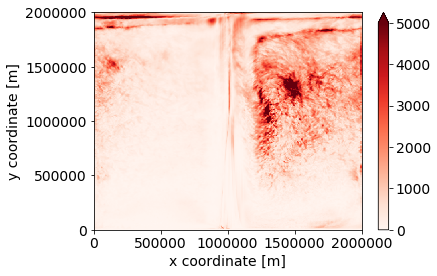

In [694]:
Kgm_approx.sel(Z=slice(-500,-2000)).mean('Z').plot(vmin=0, vmax=5000, cmap='Reds')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


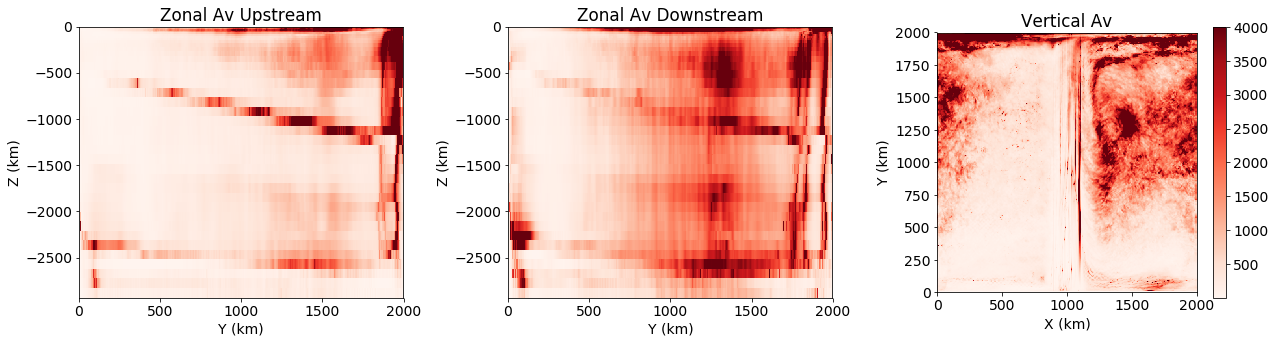

In [709]:
fig = plt.figure(figsize = (18,5))

fig.add_subplot(131)
plt.pcolormesh(X/1e3, Z, (Kgm.sel(XC=slice(0e3,800e3))*ds_model.hFacC).mean('XC'), vmax=4000, cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')

fig.add_subplot(132)
plt.pcolormesh(X/1e3, Z, (Kgm.sel(XC=slice(1200e3,2000e3))*ds_model.hFacC).mean('XC'), vmax=4000, cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Downstream')

ax = fig.add_subplot(133)
plt.pcolormesh(X/1e3, Y/1e3, (Kgm*ds_model.hFacC).mean('Z'),vmax=4000, cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Vertical Av')
ax.set_aspect('equal')
plt.colorbar()
plt.tight_layout()

plt.savefig('Kgm_5km_res.pdf', dpi=75)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


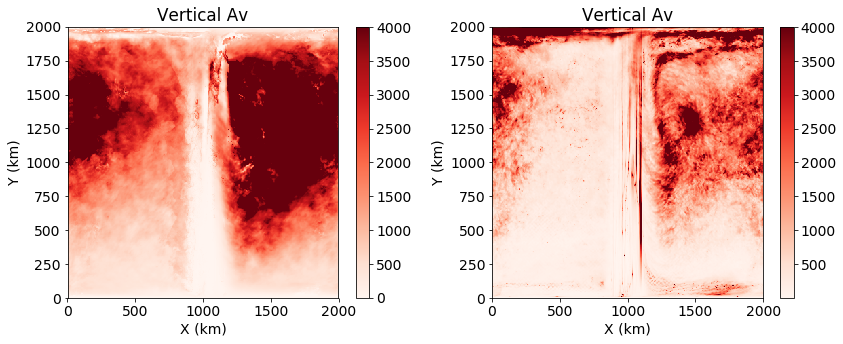

In [766]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
plt.pcolormesh(X/1e3, Y/1e3, (Kredi*ds_model.hFacC).mean('Z'),vmin=0, vmax=4000, cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Vertical Av')
ax.set_aspect('equal')
plt.colorbar()
plt.tight_layout()

ax = fig.add_subplot(122)
plt.pcolormesh(X/1e3, Y/1e3, (Kgm*ds_model.hFacC).mean('Z'),vmax=4000, cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Vertical Av')
ax.set_aspect('equal')
plt.colorbar()
plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


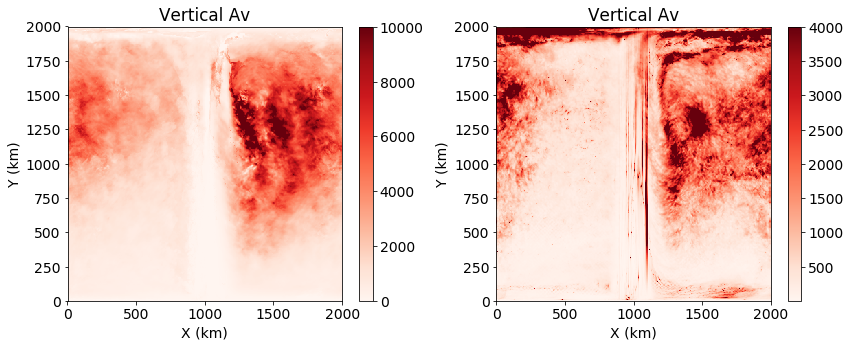

In [767]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
plt.pcolormesh(X/1e3, Y/1e3, (Kredi*ds_model.hFacC).mean('Z'),vmin=0, vmax=10000, cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Vertical Av')
ax.set_aspect('equal')
plt.colorbar()
plt.tight_layout()

ax = fig.add_subplot(122)
plt.pcolormesh(X/1e3, Y/1e3, (Kgm*ds_model.hFacC).mean('Z'),vmax=4000, cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Vertical Av')
ax.set_aspect('equal')
plt.colorbar()
plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


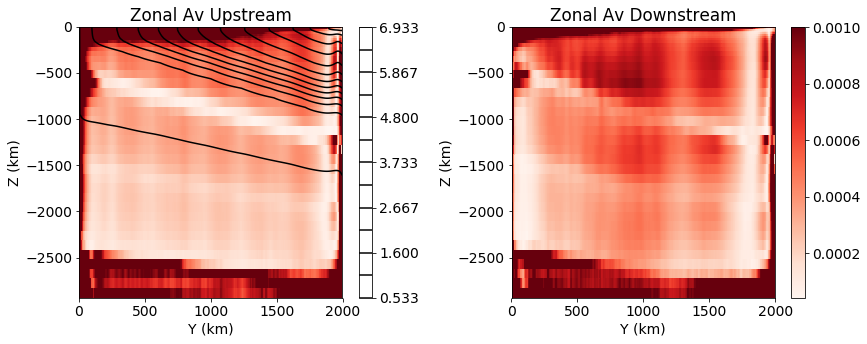

In [769]:
fig = plt.figure(figsize = (18,5))

fig.add_subplot(131)
plt.pcolormesh(X/1e3, Z, (S_mag.sel(XC=slice(0e3,800e3))*ds_model.hFacC).mean('XC'), vmax=1e-3, cmap='Reds')
plt.contour( X/1e3, Z, Model_tav.Ttave.sel(XC=slice(0e3,800e3)).mean('XC'), levels=np.linspace(0,8,16), colors='k')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(132)
plt.pcolormesh(X/1e3, Z, (S_mag.sel(XC=slice(1200e3,2000e3))*ds_model.hFacC).mean('XC'), vmax=1e-3, cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Downstream')
plt.colorbar()

plt.tight_layout()

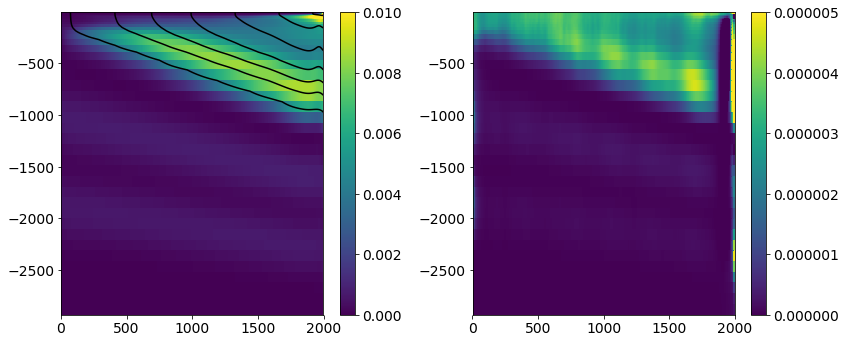

In [678]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.pcolormesh(X/1e3, Z, Tgrad['dcdz'].sel(XC=slice(0,800e3)).mean('XC'), vmax=0.01)
plt.colorbar()
plt.contour( X/1e3, Z, Model_tav.Ttave.sel(XC=slice(0e3,800e3)).mean('XC'), colors='k')

plt.subplot(122)
plt.pcolormesh(X/1e3, Z, Tgrad['dcdy'].sel(XC=slice(0,800e3)).mean('XC'), vmin=0, vmax=5e-6)
plt.colorbar()

plt.tight_layout()

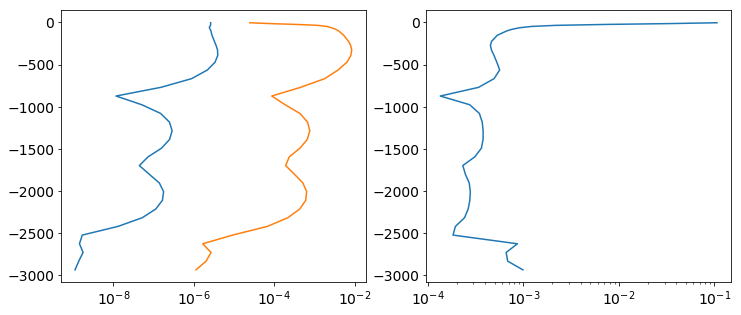

In [681]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(Tgrad['dcdy'].sel(XC=0, YC=1000e3, method='nearest'),Z)
plt.plot(Tgrad['dcdz'].sel(XC=0, YC=1000e3, method='nearest'),Z)
plt.xscale('log')


plt.subplot(122)
plt.plot((Tgrad['dcdy']/Tgrad['dcdz']).sel(XC=0, YC=1000e3, method='nearest'),Z)
plt.xscale('log')

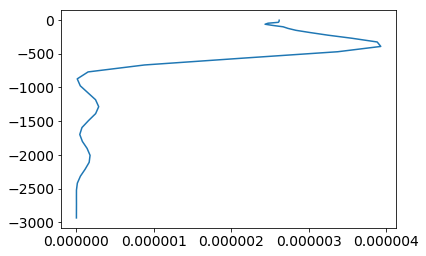

In [675]:
plt.plot(Tgrad['dcdy'].sel(XC=0, YC=1000e3, method='nearest'),Z)


# Check the buoyancy-PV relationship

\begin{equation}
K_q s_z = (K_bs)_z
\end{equation}

** This needs to be modified for the fields here **

In [740]:
# d/dz of lambda 

lambd = np.abs(eigvalsAT_reduce).max('ii')

lambd_z = grid.diff(lambd, 'Z', boundary='extend')/grid.diff(ds_model.Z, 'Z', boundary='extend')

In [748]:
s_z = grid.diff(S_mag, 'Z', boundary='extend')/grid.diff(ds_model.Z, 'Z', boundary='extend')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xgcm-0.1.0-py3.5.egg/xgcm/grid.py:880: RuntimeWarning: invalid value encountered in subtract


In [754]:
beta = 1.4e-11
f0  = -1.1e-4

In [750]:
Kredi_zl = grid.interp((eigvalsST.isel(ii=1).real), 'Z', boundary='extend')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


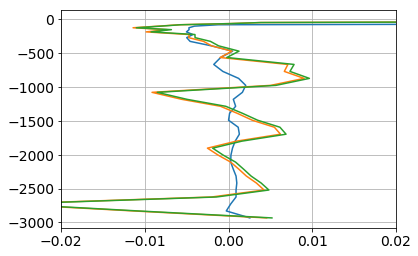

In [760]:
plt.plot(lambd_z.sel(XC=slice(1200e3,1400e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*s_z).sel(XC=slice(1200e3,1400e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*(s_z - beta/f0)).sel(XC=slice(1200e3,1400e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)

plt.xlim([-.02, 0.02])
plt.grid()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


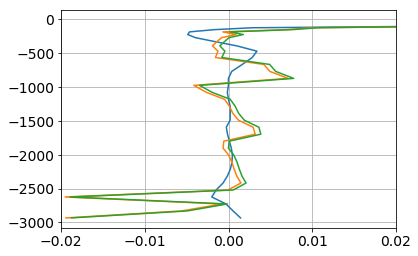

In [761]:
plt.plot(lambd_z.sel(XC=slice(1600e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*s_z).sel(XC=slice(1600e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*(s_z - beta/f0)).sel(XC=slice(1600e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)

plt.xlim([-.02, 0.02])
plt.grid()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


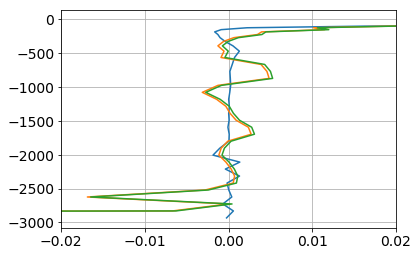

In [762]:
plt.plot(lambd_z.sel(XC=slice(0e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*s_z).sel(XC=slice(0e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*(s_z - beta/f0)).sel(XC=slice(0e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)

plt.xlim([-.02, 0.02])
plt.grid()

There are a few issues that are involved here:
- what do we aim to achieve out of these simulations? Is this meant to simply be a 3D extension of the 2D problem? 

Things to do: 
- Look at locality of fluxes. 
- How good is the K tensor at estimating the fluxes (what is the errors?)
- Look at 3D decomposition of SM2009
- Degree to which QG approximates the flux by looking at Eliassen-Palm fluxes. **this is in another notebook not **
- Visualize the flux vectors. Its a bit more challenging in the 3D case with non-zonal flows. 
- EKE, length scales, scalings. Diff scalings.
- phase speed, phase speed linear instability analaysis, critical layers.
- Does psi3 have a physical meaning? Think in terms of the Bolus velocity.

- Do we need to new runs with more constrained profiles? Why should the things not work here. 
